# Analysis of Contact Tracing Applications

In [126]:
import re
from datetime import date, timedelta, datetime

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

from tracking import config, utils

from IPython.display import display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
sns.set(style='whitegrid', font_scale=1.5)

## Loading data

In [128]:
df_apps = pd.read_csv(config.data / 'all-apps.csv')
df_scores = pd.read_csv(config.data / 'apps_scored.csv')

In [129]:
with pd.option_context('display.max_columns', None):
    display(df_apps.head())

,name,country,links,platform,data_type,bluetooth,gps,qr_code,centralized,centralized_storage,central_id_storage,central_contact_storage,central_matching,collect_pii,status,date_proposed,date_dev,date_released,date_cancelled,linkage_method,protocol,anon_method,data_persistence_days,government,contact_trace_aid,opt_in_download,opt_in_share,quarantine_enforcement,open_source,encryption,covid_positive_verification,ios_downloads,android_downloads,notes
0,CAuDHT,NaN,https://bit.ly/blecontacttracerdesign,mobile app,bluetooth,yes,no,no,NaN,NaN,NaN,NaN,NaN,NaN,proposal,NaN,NaN,NaN,2020-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,Merged with Safe2
1,Guardian,NaN,https://www.myguardian.life/,mobile app,gps,no,yes,no,NaN,NaN,NaN,NaN,NaN,yes,development,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,yes,yes,NaN,no,no,NaN,NaN,NaN,NaN,NaN
2,Hi5X,NaN,https://hi5x-app.com,mobile app,gps + QR code,yes,yes,no,NaN,NaN,NaN,NaN,NaN,NaN,released,NaN,NaN,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
3,NinjaPad,NaN,https://github.com/dantam/ninja-pad-python,mobile app,gps,no,yes,no,no,no,no,no,NaN,NaN,proposed,2020-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,yes,yes,yes,no,yes,NaN,test,NaN,NaN,seems to be discontinued
4,COVIDSafe,Australia,https://www.health.gov.au/resources/apps-and-t...,mobile app,bluetooth,yes,no,no,yes,yes,yes,no,yes,yes,released,2020-04-14,NaN,2020-04-26,NaN,exchange temporary ids,BlueTrace,pseudonymous,21,yes,yes,yes,yes,no,yes,yes,test,NaN,1778000.0,based on TraceTogether


In [130]:
df_scores.head()

,Name,Country,Links,1.1. App has defined lifetime,1.2. Data storage is time-limited,2.1. Opt-in download and use,2.2. Opt-in data sharing,2.3. Not tied to other benefits,3.1. Data used only for establishing contacts,3.2. No PII collection,...,4.2. Published privacy policy,5.1. Freely available,5.2. Android and iOS (when necessary),6.1. Decentralized storage,6.2. Can erase data,7.1. Decentralized matching,7.2. Rotating randomized beacon,"8.1. Contact accuracy (BLE, not GPS or other)",8.2. Positive cases verified by test,protocol
0,Hi5X,unknown,https://hi5x-app.com,unknown,21 days,yes,unknown,unknown,unknown,unknown,...,no,yes,both,unknown,unknown,unknown,unknown,gps + qr code,unknown,none
1,COVIDSafe,Australia,https://www.health.gov.au/resources/apps-and-t...,yes,21 days,yes,yes,yes,yes,no,...,yes,yes,both,no,yes,no,yes,ble,yes,none
2,Stopp Corona,Austria,https://www.roteskreuz.at/site/faq-app-stopp-c...,yes,14 days,yes,yes,yes,yes,yes,...,yes,yes,android only,yes,yes,yes,yes,ble,no (self-report),Apple/Google
3,BeAware,Bahrain,https://play.google.com/store/apps/details?id=...,no,no,no,no,no,no,no,...,no,yes,android only,no,no,no,no,gps + ebracelet,yes,none
4,Covid Radius,Belgium,https://www.usine-digitale.fr/article/covid-19...,no,14 days,no,no,no,yes,no,...,no,no,no,no,no,no,no,no,unknown,none


In [131]:
df_merged = pd.merge(
    df_scores,
    df_apps[['name', 'platform', 'status', 'date_proposed', 'date_dev',
             'date_released', 'date_cancelled', 'government']],
    how='left',
    left_on='Name',
    right_on='name'
).drop('name', axis=1)

In [132]:
with pd.option_context('display.max_columns', None):
    display(df_merged.head())

,Name,Country,Links,1.1. App has defined lifetime,1.2. Data storage is time-limited,2.1. Opt-in download and use,2.2. Opt-in data sharing,2.3. Not tied to other benefits,3.1. Data used only for establishing contacts,3.2. No PII collection,4.1. Open source,4.2. Published privacy policy,5.1. Freely available,5.2. Android and iOS (when necessary),6.1. Decentralized storage,6.2. Can erase data,7.1. Decentralized matching,7.2. Rotating randomized beacon,"8.1. Contact accuracy (BLE, not GPS or other)",8.2. Positive cases verified by test,protocol,platform,status,date_proposed,date_dev,date_released,date_cancelled,government
0,Hi5X,unknown,https://hi5x-app.com,unknown,21 days,yes,unknown,unknown,unknown,unknown,no,no,yes,both,unknown,unknown,unknown,unknown,gps + qr code,unknown,none,mobile app,released,NaN,NaN,2020-04-17,NaN,NaN
1,COVIDSafe,Australia,https://www.health.gov.au/resources/apps-and-t...,yes,21 days,yes,yes,yes,yes,no,yes,yes,yes,both,no,yes,no,yes,ble,yes,none,mobile app,released,2020-04-14,NaN,2020-04-26,NaN,yes
2,Stopp Corona,Austria,https://www.roteskreuz.at/site/faq-app-stopp-c...,yes,14 days,yes,yes,yes,yes,yes,yes,yes,yes,android only,yes,yes,yes,yes,ble,no (self-report),Apple/Google,mobile app,released,NaN,NaN,2020-03-27,NaN,yes
3,BeAware,Bahrain,https://play.google.com/store/apps/details?id=...,no,no,no,no,no,no,no,no,no,yes,android only,no,no,no,no,gps + ebracelet,yes,none,mobile app,released,NaN,NaN,2020-04-09,NaN,yes
4,Covid Radius,Belgium,https://www.usine-digitale.fr/article/covid-19...,no,14 days,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,unknown,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
df_merged.loc[0][['Name', 'Country']]

Name          Hi5X
Country    unknown
Name: 0, dtype: object

In [369]:
question2col = {
    '1.1. App has defined lifetime': '11_defined_lifetime',
    '1.2. Data storage is time-limited': '12_storage_time_limited',
    '2.1. Opt-in download and use': '21_opt_in_download_use',
    '2.2. Opt-in data sharing': '22_opt_in_share', 
    '2.3. Not tied to other benefits': '23_other_benefits',
    '3.1. Data used only for establishing contacts': '31_only_contacts',
    '3.2. No PII collection': '32_no_pii',
    '4.1. Open source': '41_open_source',
    '4.2. Published privacy policy': '42_privacy_policy',
    '5.1. Freely available': '51_free',
    '5.2. Android and iOS (when necessary)': '52_android_ios',
    '6.1. Decentralized storage': '61_decentralized_storage',
    '6.2. Can erase data': '62_erase_data',
    '7.1. Decentralized matching': '71_decentralized_matching',
    '7.2. Rotating randomized beacon': '72_rotating_randomized',
    '8.1. Contact accuracy (BLE, not GPS or other)': '81_ble_only',
    '8.2. Positive cases verified by test': '82_verify_test'
}
col2question = {c: q for q, c in question2col.items()}    

    
def replace_days(x):
    if x == 'no' or x == 'unknown':
        return x
    else:
        return 'yes'


def replace_data_use(x):
    if x == 'na':
        return 'unknown'
    elif x == 'yes':
        return 'yes'
    else:
        return 'no'

    
def replace_contact_accuracy(x):
    if x == 'ble':
        return 'yes'
    elif 'ble' in 'x':
        return 'unknown'
    elif x == 'unknown':
        return 'unknown'
    else:
        return 'no'
    

def replace_test(x):
    if x == 'na':
        return 'unknown'
    elif x in ['yes', 'unknown']:
        return x
    else:
        return 'no'
    

replace_dct = {
    'na': 'unknown',
    'no (WOM vouchers)': 'no',
    'maybe': 'unknown',
    'no (public spaces)': 'no',
    'maybe (blockchain)': 'unknown',
    'both': 'yes',
    'android only': 'yes',
    'iOS only': 'no'
}
replace_vals = {
    'no': -1,
    'maybe': 0,
    'unknown': 0,
    'yes': 1
}

df_coded = df_merged.rename(columns=question2col)
df_coded['has_protocol'] = df_coded['protocol'].apply(lambda x: 'yes' if x != 'none' else 'no')
df_coded['12_storage_time_limited'] = df_coded['12_storage_time_limited'].apply(replace_days)
df_coded['31_only_contacts'] = df_coded['31_only_contacts'].apply(replace_data_use)
df_coded['81_ble_only'] = df_coded['81_ble_only'].apply(replace_contact_accuracy)
df_coded['82_verify_test'] = df_coded['82_verify_test'].apply(replace_test)
for col in col_rename.values():
    df_coded[col] = df_coded[col].replace(replace_dct).replace(replace_vals)

In [316]:
utils.display_all(df_coded)

,Name,Country,Links,11_defined_lifetime,12_storage_time_limited,21_opt_in_download_use,22_opt_in_share,23_other_benefits,31_only_contacts,32_no_pii,41_open_source,42_privacy_policy,51_free,52_android_ios,61_decentralized_storage,62_erase_data,71_decentralized_matching,72_rotating_randomized,81_ble_only,82_verify_test,protocol,platform,status,date_proposed,date_dev,date_released,date_cancelled,government,has_protocol
0,Hi5X,unknown,https://hi5x-app.com,0,1,1,0,0,-1,0,-1,-1,1,1,0,0,0,0,-1,0,none,mobile app,released,NaN,NaN,2020-04-17,NaN,NaN,no
1,COVIDSafe,Australia,https://www.health.gov.au/resources/apps-and-t...,1,1,1,1,1,1,-1,1,1,1,1,-1,1,-1,1,1,1,none,mobile app,released,2020-04-14,NaN,2020-04-26,NaN,yes,no
2,Stopp Corona,Austria,https://www.roteskreuz.at/site/faq-app-stopp-c...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,Apple/Google,mobile app,released,NaN,NaN,2020-03-27,NaN,yes,yes
3,BeAware,Bahrain,https://play.google.com/store/apps/details?id=...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,1,none,mobile app,released,NaN,NaN,2020-04-09,NaN,yes,no
4,Covid Radius,Belgium,https://www.usine-digitale.fr/article/covid-19...,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
5,Unmaze,Bulgaria,http://cyborgsys.com/unmaze/,-1,-1,0,0,0,-1,0,-1,-1,-1,0,0,0,0,0,-1,0,none,mobile app,released,NaN,NaN,NaN,NaN,no,no
6,Unmaze,Bulgaria,http://cyborgsys.com/unmaze/,-1,-1,0,0,0,-1,0,-1,-1,-1,0,0,0,0,0,-1,0,none,NaN,released,NaN,NaN,NaN,NaN,NaN,no
7,ViruSafe,Bulgaria,https://play.google.com/store/apps/details?id=...,-1,0,1,1,0,1,-1,1,1,1,1,0,0,-1,0,-1,0,none,mobile app,released,NaN,NaN,2020-04-07,NaN,yes,no
8,ABTraceTogether,Canada,https://www.alberta.ca/ab-trace-together-priva...,1,1,1,1,1,1,1,-1,1,1,1,-1,1,-1,1,1,1,OpenTrace,mobile app,released,NaN,NaN,2020-05-01,NaN,yes,yes
9,ConTrac,Canada,https://livnao.com/covid19/,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,0,0,0,-1,0,0,0,none,mobile app,released,NaN,NaN,2020-04-25,NaN,no,no


In [317]:
def score_app(row):
    colnames = row.index
    total_score = 0.
    for i in range(1, 9):
        s = str(i)
        cols = [col for col in colnames if col.startswith(s)]
        max_col_score = len(cols)
        
        col_score = 0
        for j, col in enumerate(cols):
            j += 1
            col_score += row[col]
        col_score /= max_col_score
        total_score += col_score
    return total_score

In [318]:
df_scored = df_coded.assign(score=lambda df: df.apply(score_app, axis=1))

In [319]:
df_scored['score'].mean()

1.1650793650793652

In [320]:
utils.display_all(df_scored.sort_values('score', ascending=False))

,Name,Country,Links,11_defined_lifetime,12_storage_time_limited,21_opt_in_download_use,22_opt_in_share,23_other_benefits,31_only_contacts,32_no_pii,41_open_source,42_privacy_policy,51_free,52_android_ios,61_decentralized_storage,62_erase_data,71_decentralized_matching,72_rotating_randomized,81_ble_only,82_verify_test,protocol,platform,status,date_proposed,date_dev,date_released,date_cancelled,government,has_protocol,score
56,Immuni,Italy,https://www.nytimes.com/reuters/2020/04/17/tec...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,Apple/Google,mobile app,development,NaN,2020-05-13,NaN,NaN,yes,yes,8.000000
2,Stopp Corona,Austria,https://www.roteskreuz.at/site/faq-app-stopp-c...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,Apple/Google,mobile app,released,NaN,NaN,2020-03-27,NaN,yes,yes,7.000000
65,Wiqaytna,Morocco,https://www.wiqaytna.ma/Default_Fr.aspx,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,none,mobile app,released,NaN,NaN,2020-05-31,NaN,yes,no,7.000000
60,Apturi Covid,Latvia,https://apturicovid.lv/#en,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,Apple/Google,mobile app,released,NaN,NaN,2020-05-29,NaN,yes,yes,7.000000
73,ProteGO,Poland,github.com/ProteGO-app,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,Apple/Google,mobile app,released,NaN,NaN,2020-04-30,NaN,yes,yes,7.000000
25,Corona-Warn-App,Germany,https://www.coronawarn.app/,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,TCN + DP3T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,7.000000
104,WeTrace,Switzerland,https://wetrace.ch/,-1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,none,mobile app,released,NaN,NaN,2020-04-06,NaN,NaN,no,6.166667
51,HSE Covid-19 App,Ireland,https://github.com/HSEIreland/,-1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,Apple/Google,mobile app,development,NaN,2020-05-30,NaN,NaN,NaN,yes,6.000000
18,ERouška,Czechia,https://erouska.cz,-1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,none,mobile app,released,NaN,NaN,2020-04-12,NaN,yes,no,6.000000
88,CoEpi,United States,https://www.coepi.org,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,TCN,mobile app,development,NaN,2020-03-22,NaN,NaN,no,yes,6.000000


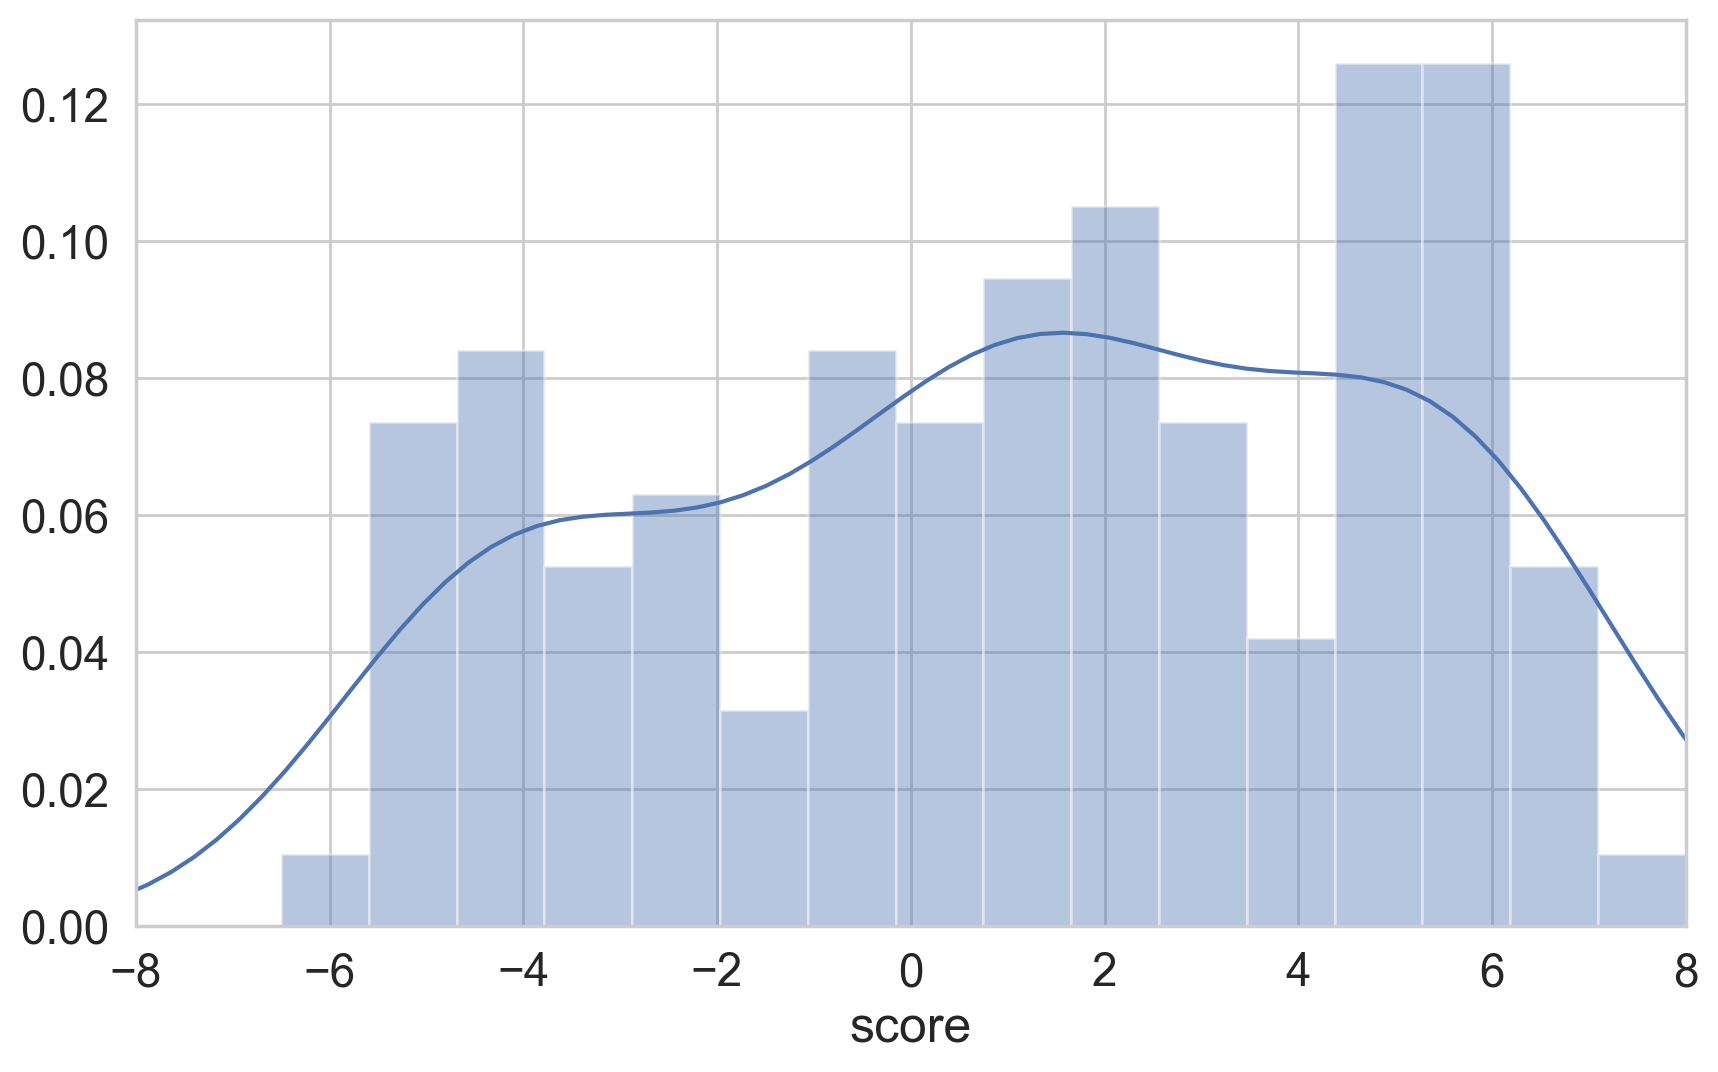

In [321]:
plt.figure(dpi=200, figsize=(10, 6))
sns.distplot(df_scored['score'], bins=16)
plt.xlim(-8, 8);

In [322]:
df_scored['score'].mean()

1.1650793650793652

In [323]:
qnorm_95 = sps.norm.ppf(0.975)
qnorm_95

1.959963984540054

In [420]:
df_gov = (df_scored[['government', 'score']]
          .groupby('government')
          .agg(['mean', 'std']))
df_protocol = (df_scored[['has_protocol', 'score']]
               .groupby('has_protocol')
               .agg(['mean', 'std']))
df_gov.columns = df_protocol.columns = ['mean', 'std']

In [421]:
df_gov

,mean,std
government,,
no,2.500000,3.024393
yes,0.777778,3.969000


In [422]:
df_protocol

,mean,std
has_protocol,,
no,-0.405093,3.361830
yes,4.590909,1.909902


<ErrorbarContainer object of 3 artists>

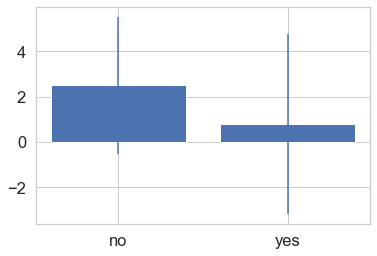

In [423]:
plt.bar(df_gov.index, df_gov['mean'])
plt.errorbar(df_gov.index, df_gov['mean'], yerr=df_gov['std'], fmt='none')

<ErrorbarContainer object of 3 artists>

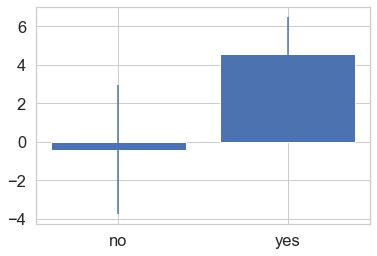

In [424]:
plt.bar(df_protocol.index, df_protocol['mean'])
plt.errorbar(df_protocol.index, df_protocol['mean'], yerr=df_protocol['std'], fmt='none')

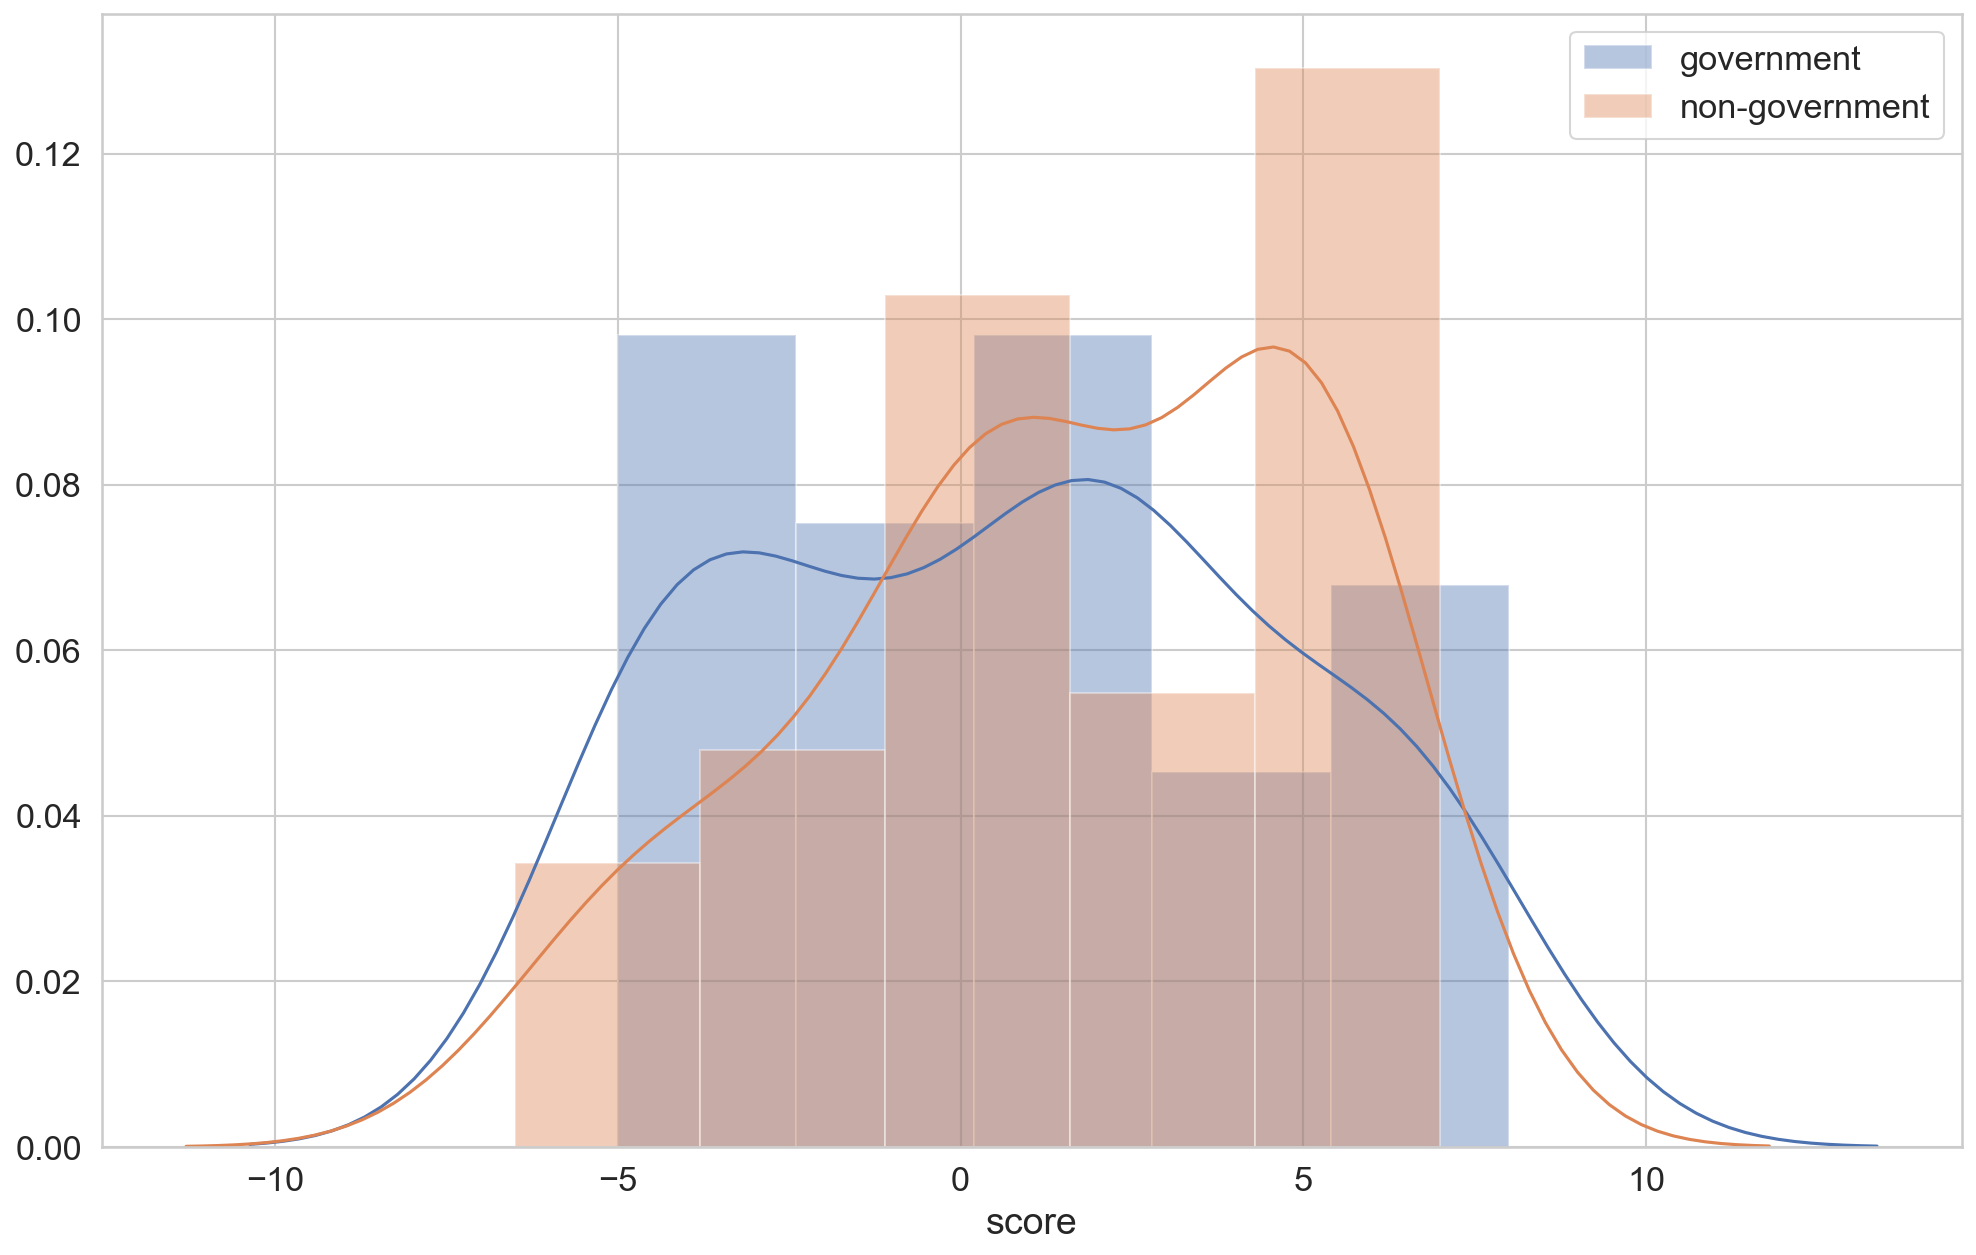

In [328]:
plt.figure(dpi=150, figsize=(16, 10))
sns.distplot(df_scored.loc[df_scored['government'] == 'yes', 'score'], label='government')
sns.distplot(df_scored.loc[df_scored['government'] != 'yes', 'score'], label='non-government')
plt.legend()

In [329]:
(df_scored
 [['has_protocol', 'score']]
 .groupby('has_protocol')
 .agg(['mean', 'std']))

score          
                  mean       std
has_protocol                    
no           -0.405093  3.361830
yes           4.590909  1.909902

In [330]:
(df_scored
 [['has_protocol', 'government']]
 .groupby(['government', 'has_protocol'])
 .size())

government  has_protocol
no          no              19
            yes             13
yes         no              36
            yes             15
dtype: int64

In [331]:
df_scored[['41_open_source', 'score']].groupby('41_open_source').agg('mean')

,score
41_open_source,
-1,-0.944444
0,4.500000
1,4.320833


In [332]:
df_scored.columns

Index(['Name', 'Country', 'Links', '11_defined_lifetime',
       '12_storage_time_limited', '21_opt_in_download_use', '22_opt_in_share',
       '23_other_benefits', '31_only_contacts', '32_no_pii', '41_open_source',
       '42_privacy_policy', '51_free', '52_android_ios',
       '61_decentralized_storage', '62_erase_data',
       '71_decentralized_matching', '72_rotating_randomized', '81_ble_only',
       '82_verify_test', 'protocol', 'platform', 'status', 'date_proposed',
       'date_dev', 'date_released', 'date_cancelled', 'government',
       'has_protocol', 'score'],
      dtype='object')

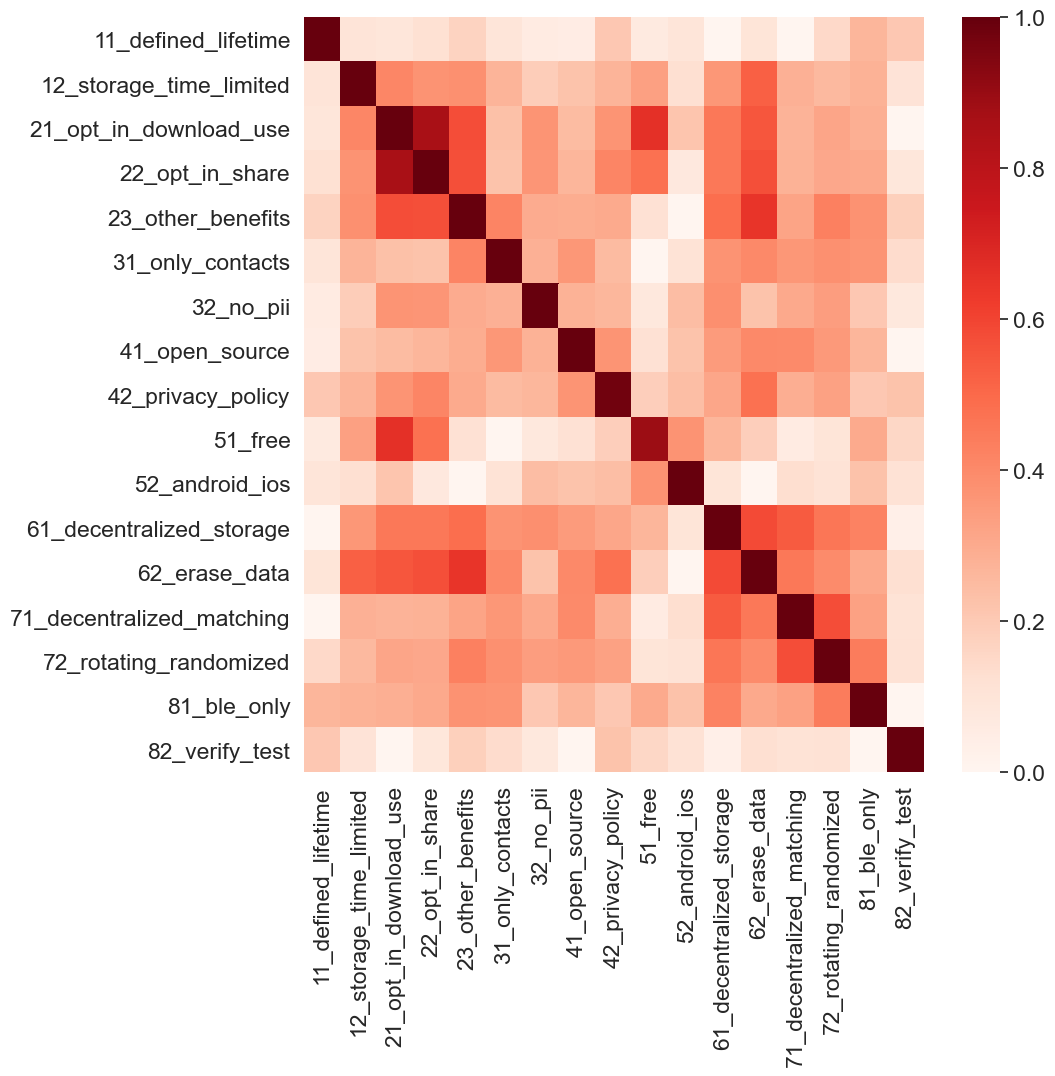

In [464]:
# Association between variables
feature_cols = list(col_rename.values())
v_stats = np.zeros((len(feature_cols), len(feature_cols)), dtype=np.float32)
for i, c1 in enumerate(feature_cols):
    for j, c2 in enumerate(feature_cols):
        v_stats[i, j] = utils.cramers_v_corrected(df_scored[c1], df_scored[c2])

plt.figure(dpi=100, figsize=(10, 10))
sns.heatmap(v_stats, cmap='Reds')
plt.xticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=90);
plt.yticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=0);

In [468]:
subset

,Name,Country,Links,11_defined_lifetime,12_storage_time_limited,21_opt_in_download_use,22_opt_in_share,23_other_benefits,31_only_contacts,32_no_pii,...,protocol,platform,status,date_proposed,date_dev,date_released,date_cancelled,government,has_protocol,score
2,Stopp Corona,Austria,https://www.roteskreuz.at/site/faq-app-stopp-c...,1,1,1,1,1,1,1,...,Apple/Google,mobile app,released,NaN,NaN,2020-03-27,NaN,yes,yes,7.000000
8,ABTraceTogether,Canada,https://www.alberta.ca/ab-trace-together-priva...,1,1,1,1,1,1,1,...,OpenTrace,mobile app,released,NaN,NaN,2020-05-01,NaN,yes,yes,5.000000
11,COVID Alert,Canada,https://www.cbc.ca/news/politics/contact-traci...,1,1,1,1,1,1,1,...,Apple/Google,mobile app,development,NaN,2020-06-18,NaN,NaN,yes,yes,6.000000
12,flaat,Canada,https://app.flaat.io/,0,0,1,1,1,1,0,...,TCN,mobile app,development,NaN,2020-04-17,NaN,NaN,no,yes,5.500000
16,CoronApp,Colombia,https://coronaviruscolombia.gov.co/test/aislam...,0,0,1,0,1,1,1,...,OpenTrace,mobile app,released,NaN,NaN,2020-03-15,NaN,yes,yes,1.666667
17,CovTracer,Cyprus,https://covid-19.rise.org.cy/en/,-1,1,1,1,1,-1,1,...,SafePaths,mobile app,released,NaN,NaN,2020-05-15,NaN,yes,yes,2.000000
19,Unnamed,Estonia,https://e-estonia.com/trace-covid-19-while-res...,0,1,1,1,1,1,0,...,DP3T,mobile app,proposed,NaN,2020-04-15,NaN,NaN,NaN,yes,4.500000
21,Epidose,EU,https://github.com/dspinellis/epidose,0,0,1,1,0,1,1,...,DP3T,raspberry pi,development,NaN,2020-04-10,NaN,NaN,no,yes,5.166667
23,StopCovid,France,https://www.orange.com/en/content/download/541...,1,0,1,1,1,-1,0,...,ROBERT,mobile app,development,NaN,2020-05-05,NaN,NaN,yes,yes,2.000000
24,Stop Covid,Georgia,https://play.google.com/store/apps/details?id=...,0,0,1,1,1,1,0,...,PEPP-PT,mobile app,released,NaN,NaN,2020-04-04,NaN,yes,yes,2.500000


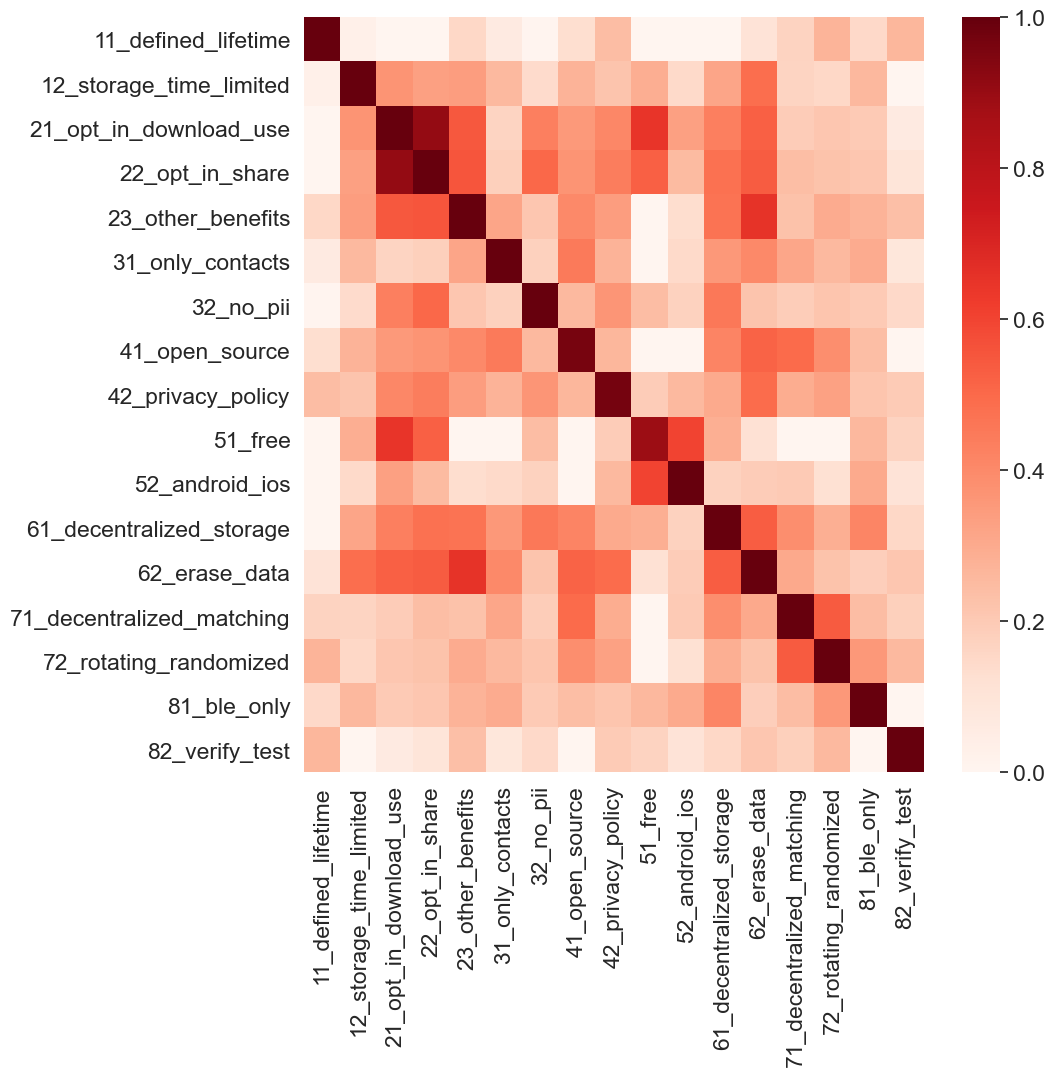

In [471]:
# Association between variables
subset = df_scored.query('has_protocol == "no"')
feature_cols = list(col_rename.values())
v_stats = np.zeros((len(feature_cols), len(feature_cols)), dtype=np.float32)
for i, c1 in enumerate(feature_cols):
    for j, c2 in enumerate(feature_cols):
        if np.all(subset[c1] == 1) or np.all(subset[c2] == 1):
            continue
        v_stats[i, j] = utils.cramers_v_corrected(subset[c1], subset[c2])

plt.figure(dpi=100, figsize=(10, 10))
sns.heatmap(v_stats, cmap='Reds')
plt.xticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=90);
plt.yticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=0);

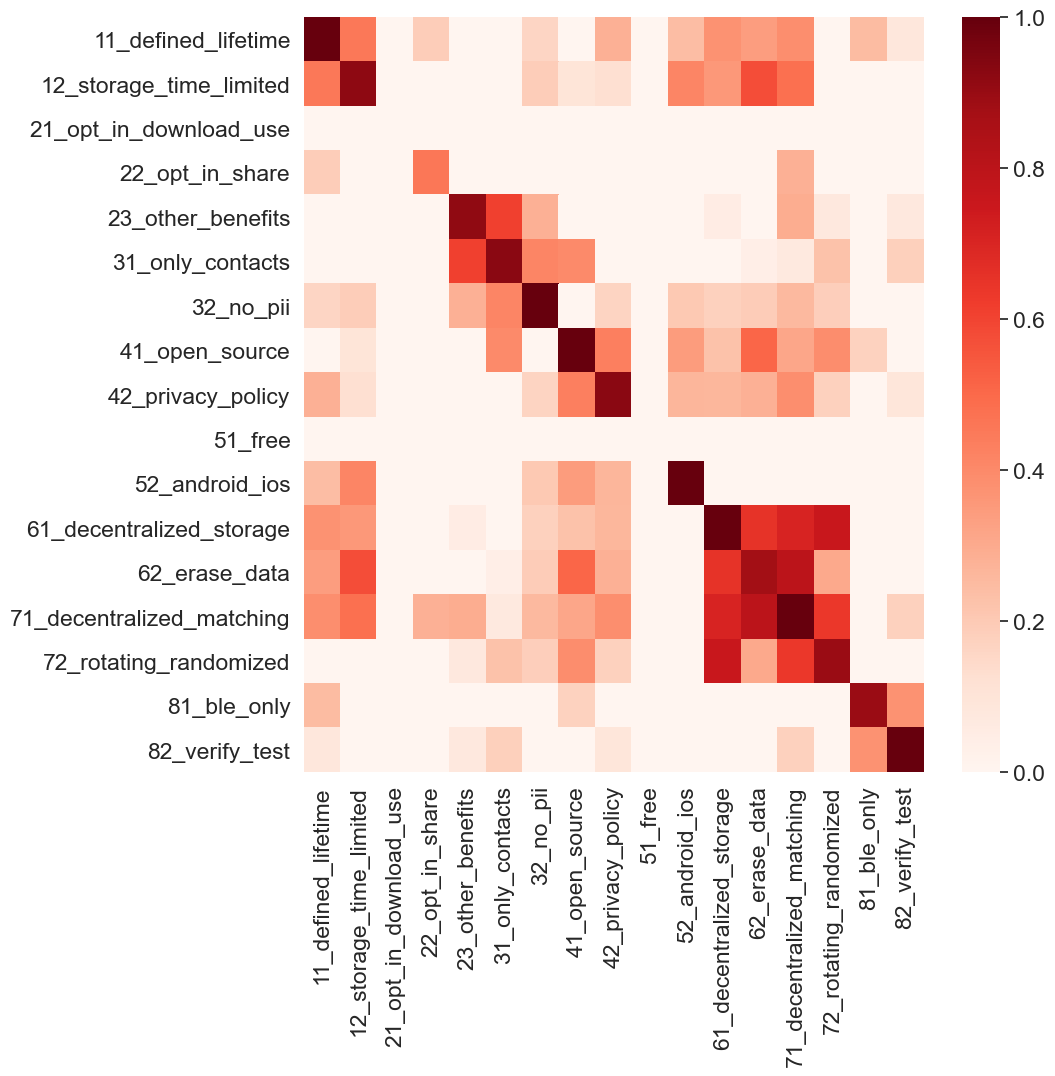

In [470]:
# Association between variables
subset = df_scored.query('has_protocol == "yes"')
feature_cols = list(col_rename.values())
v_stats = np.zeros((len(feature_cols), len(feature_cols)), dtype=np.float32)
for i, c1 in enumerate(feature_cols):
    for j, c2 in enumerate(feature_cols):
        if np.all(subset[c1] == 1) or np.all(subset[c2] == 1):
            continue
        v_stats[i, j] = utils.cramers_v_corrected(subset[c1], subset[c2])

plt.figure(dpi=100, figsize=(10, 10))
sns.heatmap(v_stats, cmap='Reds')
plt.xticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=90);
plt.yticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=0);

Looking at the percentages for each sub-question, broken up by

- Overall
- Government
- Protocol
- Open source
- Country group (choose this)

In [336]:
df_scored[['11_defined_lifetime', 'government']].groupby('government').agg('mean')

,11_defined_lifetime
government,
no,-0.625000
yes,-0.372549


In [385]:
data = []
groupcols = ['government', 'has_protocol', '41_open_source']
for col in feature_cols + ['Number of apps', 'Average score']:

    # Total
    question = col if col in ['Number of apps', 'Average score'] else col2question[col]
    row = [question]
    
    if col == 'Number of apps':
        row.append(df_scored.shape[0])
    elif col == 'Average score':
        row.append(df_scored['score'].mean())
    else:
        row.append(np.mean(df_scored[col] == 1))
        question = col2question[col]
    
    for groupcol in groupcols:
        ix = np.logical_or(df_scored[groupcol] == 1, df_scored[groupcol] == 'yes')
        for i in [ix, ~ix]:
            if col == 'Number of apps':
                row.append(np.sum(i))
            elif col == 'Average score':
                row.append(np.mean(df_scored.loc[i, 'score']))
            else:
                row.append(np.mean(df_scored.loc[i, col] == 1))
                    
    data.append(row)

cols = pd.MultiIndex.from_tuples([
    ('question',''), ('total',''),
    ('government', 'yes',), ('government', 'no'),
    ('protocol', 'yes'), ('protocol', 'no'),
    ('open_source', 'yes'), ('open_source', 'no')
])
df_question_stats = pd.DataFrame(data, columns=cols).set_index(('question', ''))
df_question_stats.index.name = 'Question'

/Users/benjaminlevy/Desktop/Benjamin/School/19_20/Classes/spring/ac221/final-project/covid-tracking-env/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [416]:
questions = list(question2col.keys())
lightred = sns.xkcd_palette(['light red'])[0]
def style_proportion(a, color='light red'):
    rgb = list(sns.xkcd_palette([color])[0])
    for i in range(len(rgb)):
        rgb[i] = int(rgb[i] * 255)
    r, g, b = rgb
    return f'background-color: rgba({r},{g},{b},{a})'
    
# df_question_stats[('question', '')] = list(col_rename.keys())
(df_question_stats
 .style
 .applymap(style_proportion, subset=pd.IndexSlice[questions, :])
 .format("{:.1%}", subset=pd.IndexSlice[questions, :])
 .format(lambda x: int(x), subset=pd.IndexSlice['Number of apps', :])
 .format("{:.2f}", subset=pd.IndexSlice['Average score', :]))

## Countries

In [456]:
displaydata = df_scored.query('government == "yes"').groupby('Country').agg({'score': ['mean', 'count']})
displaydata.columns = ['mean', 'count']
displaydata = displaydata.sort_values('mean', ascending=True)

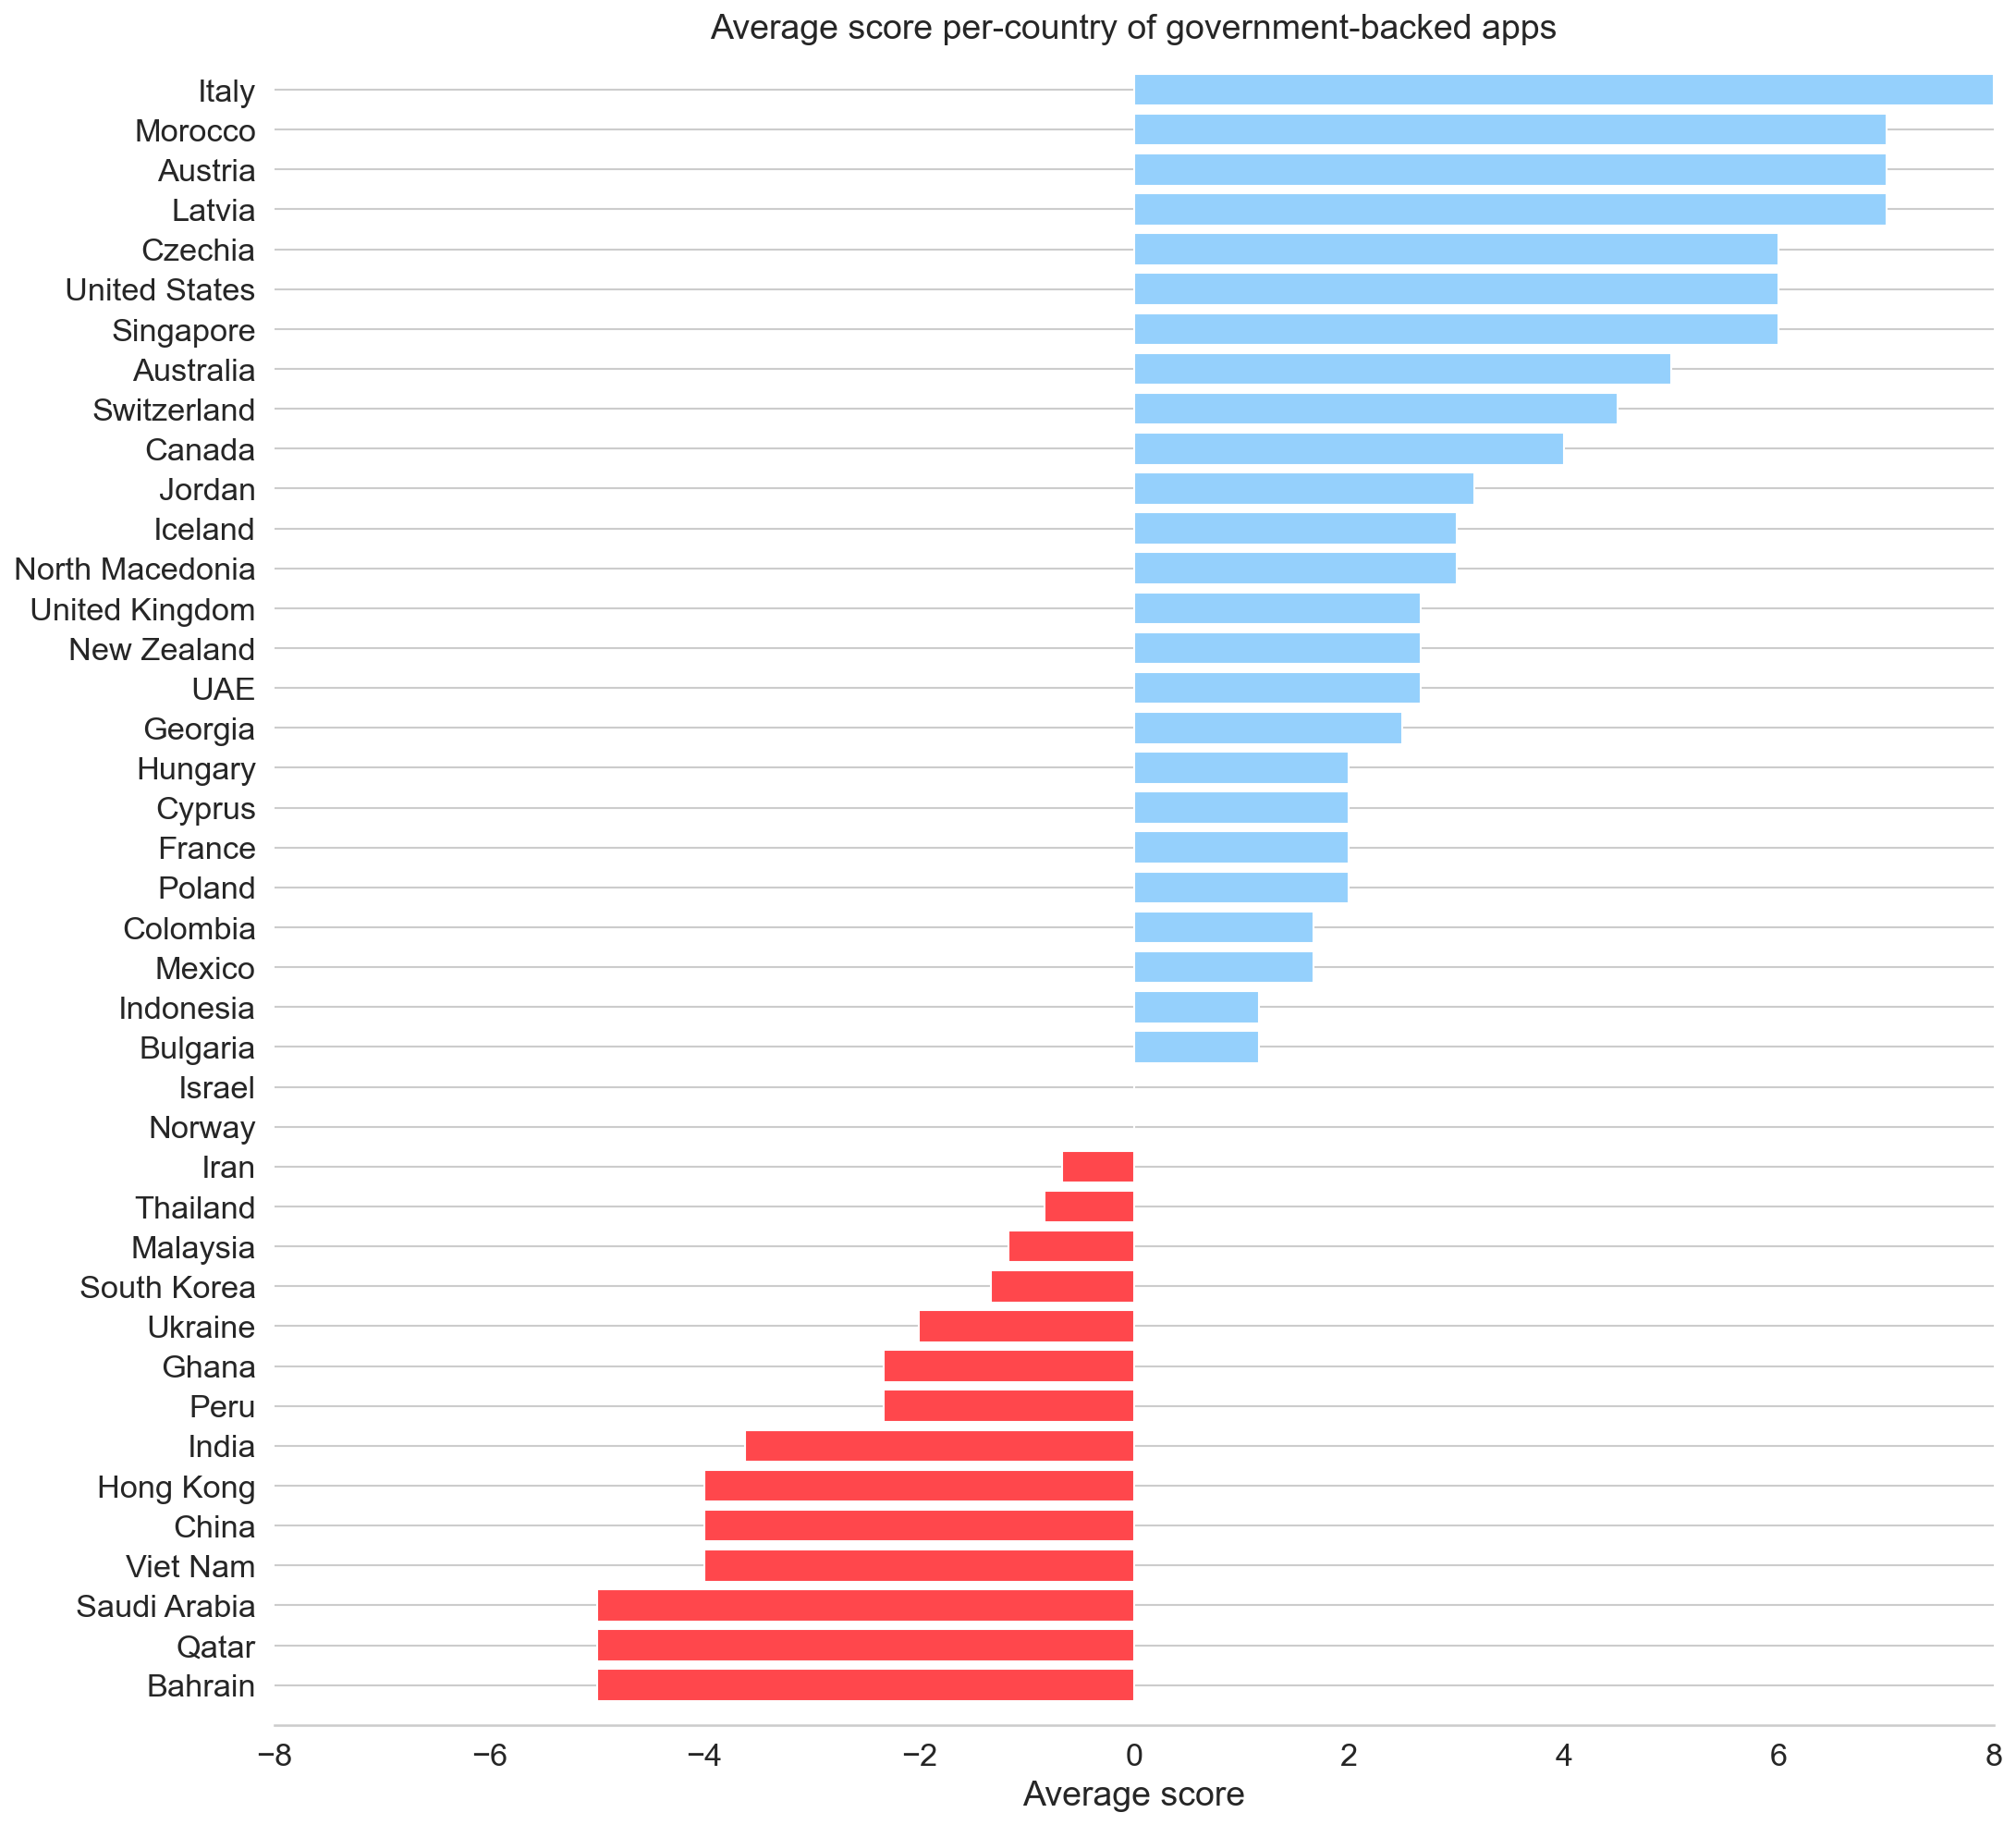

In [463]:
plt.figure(dpi=150, figsize=(16, 16))
col_neg, col_pos = sns.xkcd_palette(['light red', 'light blue'])
colors = []
for score in displaydata['mean']:
    if score < 0:
        colors.append(col_neg)
    else:
        colors.append(col_pos)
plt.barh(displaydata.index, displaydata['mean'], color=colors)
plt.grid(b=None, axis='x')

plt.ylim(-1, len(displaydata))
plt.xlim(-8, 8)

ax = plt.gca()
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
plt.title("Average score per-country of government-backed apps")
plt.xlabel("Average score")
plt.savefig(config.figs / 'avg_country_score_govt_apps.png', dpi=200);

## Time series

In [251]:
# Converting into a list where each element is a unique date with all the apps that existed on that date
start_date = date(2020, 2, 1) # February 1, 2020
end_date = date(2020, 7, 1) # July 1, 2020

days = {}
curr = start_date
while curr <= end_date:
    days[curr] = []
    curr += timedelta(days=1)

In [477]:
statuses = ['proposed', 'dev', 'released', 'cancelled']
for idx, row in df_scored.iterrows():
    dct = row.to_dict()
    app_statuses = []
    for status in statuses:
        status_date = dct[f'date_{status}']
        if not pd.isna(status_date):
            d = date(*[int(i) for i in status_date.split('-')])
            app_statuses.append((status, d))
    app_statuses.append(('end', end_date + timedelta(days=1)))
    
    for i in range(len(app_statuses) - 1):
        dct_cp = dct.copy()
        s, d0 = app_statuses[i]
        _, d1 = app_statuses[i + 1]
        dct_cp['status'] = s
        curr = d0
        while curr < d1:
            li = days[curr]
            li.append(dct_cp)
            days[curr] = li
            curr += timedelta(days=1)

In [478]:
def plot_time_series(groupvar, unknown=None, status=None, stacked=True):
    data = []
    for d, apps in days.items():
        row = {'date': d}
        for app in apps:
            if status is not None:
                if type(status) not in [list, tuple]:
                    status = [status]
                if app['status'] not in status:
                    continue
            level = app[groupvar]
            if unknown is not None or unknown == 'show':
                if level == 'unknown':
                    if unknown in ['drop', 'hide']:
                        continue
                    else:
                        level = unknown
            currval = row.get(level, 0)
            currval += 1
            row[level] = currval
        data.append(row)
    df_time = pd.DataFrame(data).fillna(0)

    plt.figure(figsize=(16, 6), dpi=200)
    y0 = np.zeros(len(df_time))
    x = df_time['date']
    for level in np.sort(df_time.columns[1:]):
        y1 = df_time[level]
        plt.fill_between(x, y0, y1 + y0, label=level, alpha=0.4)
        if stacked:
            y0 += y1
    plt.legend(loc='upper left')
    if stacked:
        ymax = max(y0)
        plt.ylim(0, ymax)
    plt.xlim(start_date, end_date)
    plt.title(groupvar)
    plt.grid(b=None)
    ax = plt.gca()
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        

def plot_score_time_series(status=None, stacked=False, ):
    data = []
    for d, apps in days.items():
        row = {'date': d}
        day_total_score = 0.
        day_count = 0.
        for app in apps:
            if status is not None:
                if type(status) not in [list, tuple]:
                    status = [status]
                if app['status'] not in status:
                    continue
            day_total_score += app['score']
            day_count += 1.
        row['avg_score'] = day_total_score / day_count if day_count > 0 else 0
        data.append(row)
    df_time = pd.DataFrame(data).fillna(0)

    plt.figure(figsize=(16, 6), dpi=200)
    y0 = np.zeros(len(df_time))
    x = df_time['date']
    for level in np.sort(df_time.columns[1:]):
        y1 = df_time['avg_score']
        plt.fill_between(x, y0, y1 + y0, label=level, alpha=0.4)
        if stacked:
            y0 += y1
    plt.legend(loc='upper left')
    if stacked:
        ymax = max(y0)
        plt.ylim(0, ymax)
    plt.xlim(start_date, end_date)
    plt.title("Score over time")
    plt.grid(b=None)
    ax = plt.gca()
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        

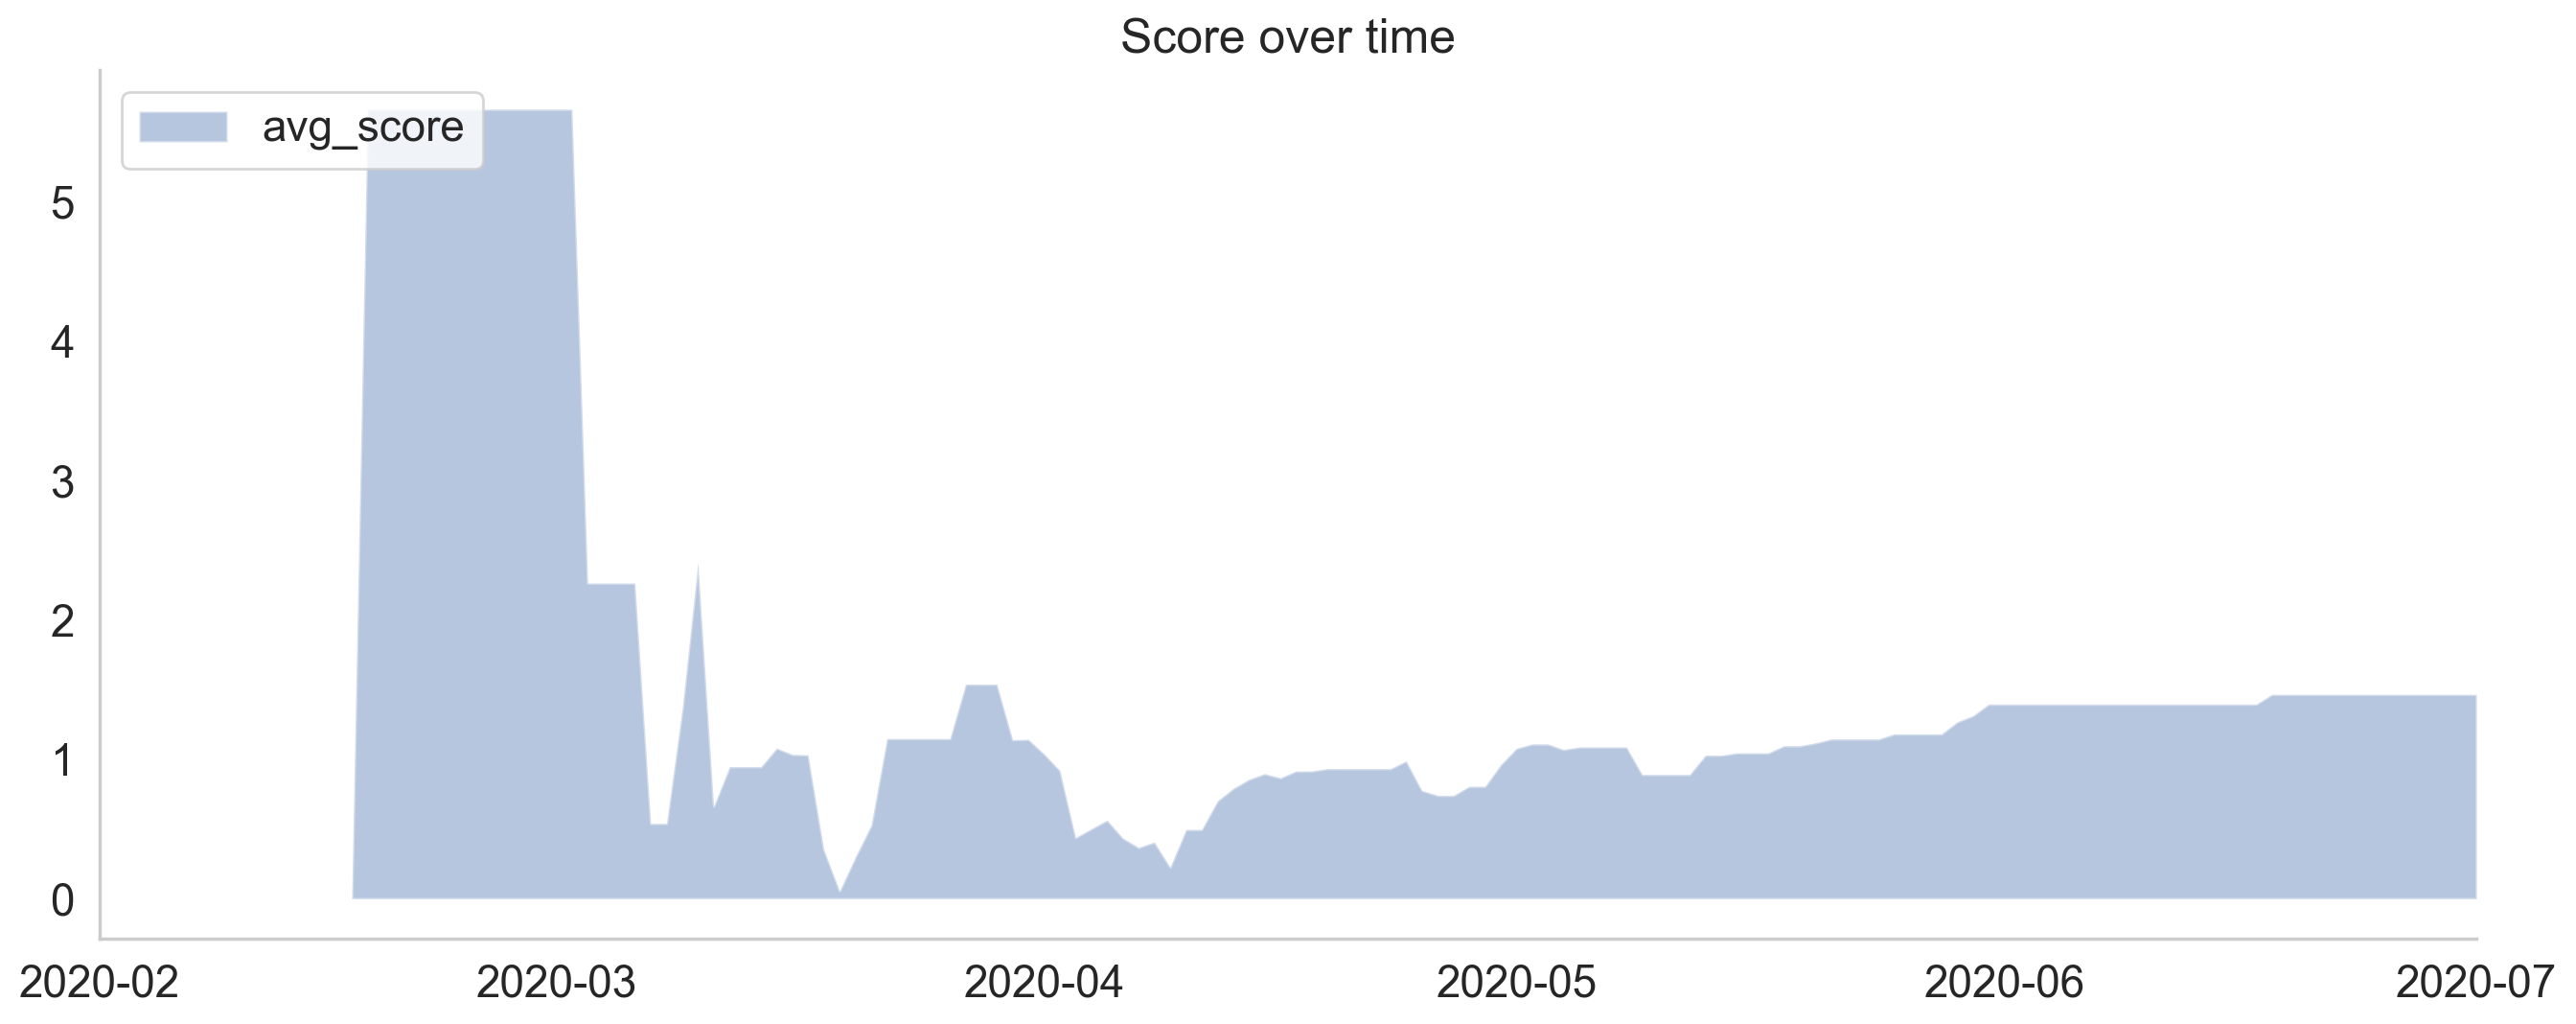

In [479]:
plot_score_time_series(status=['released', 'dev'])

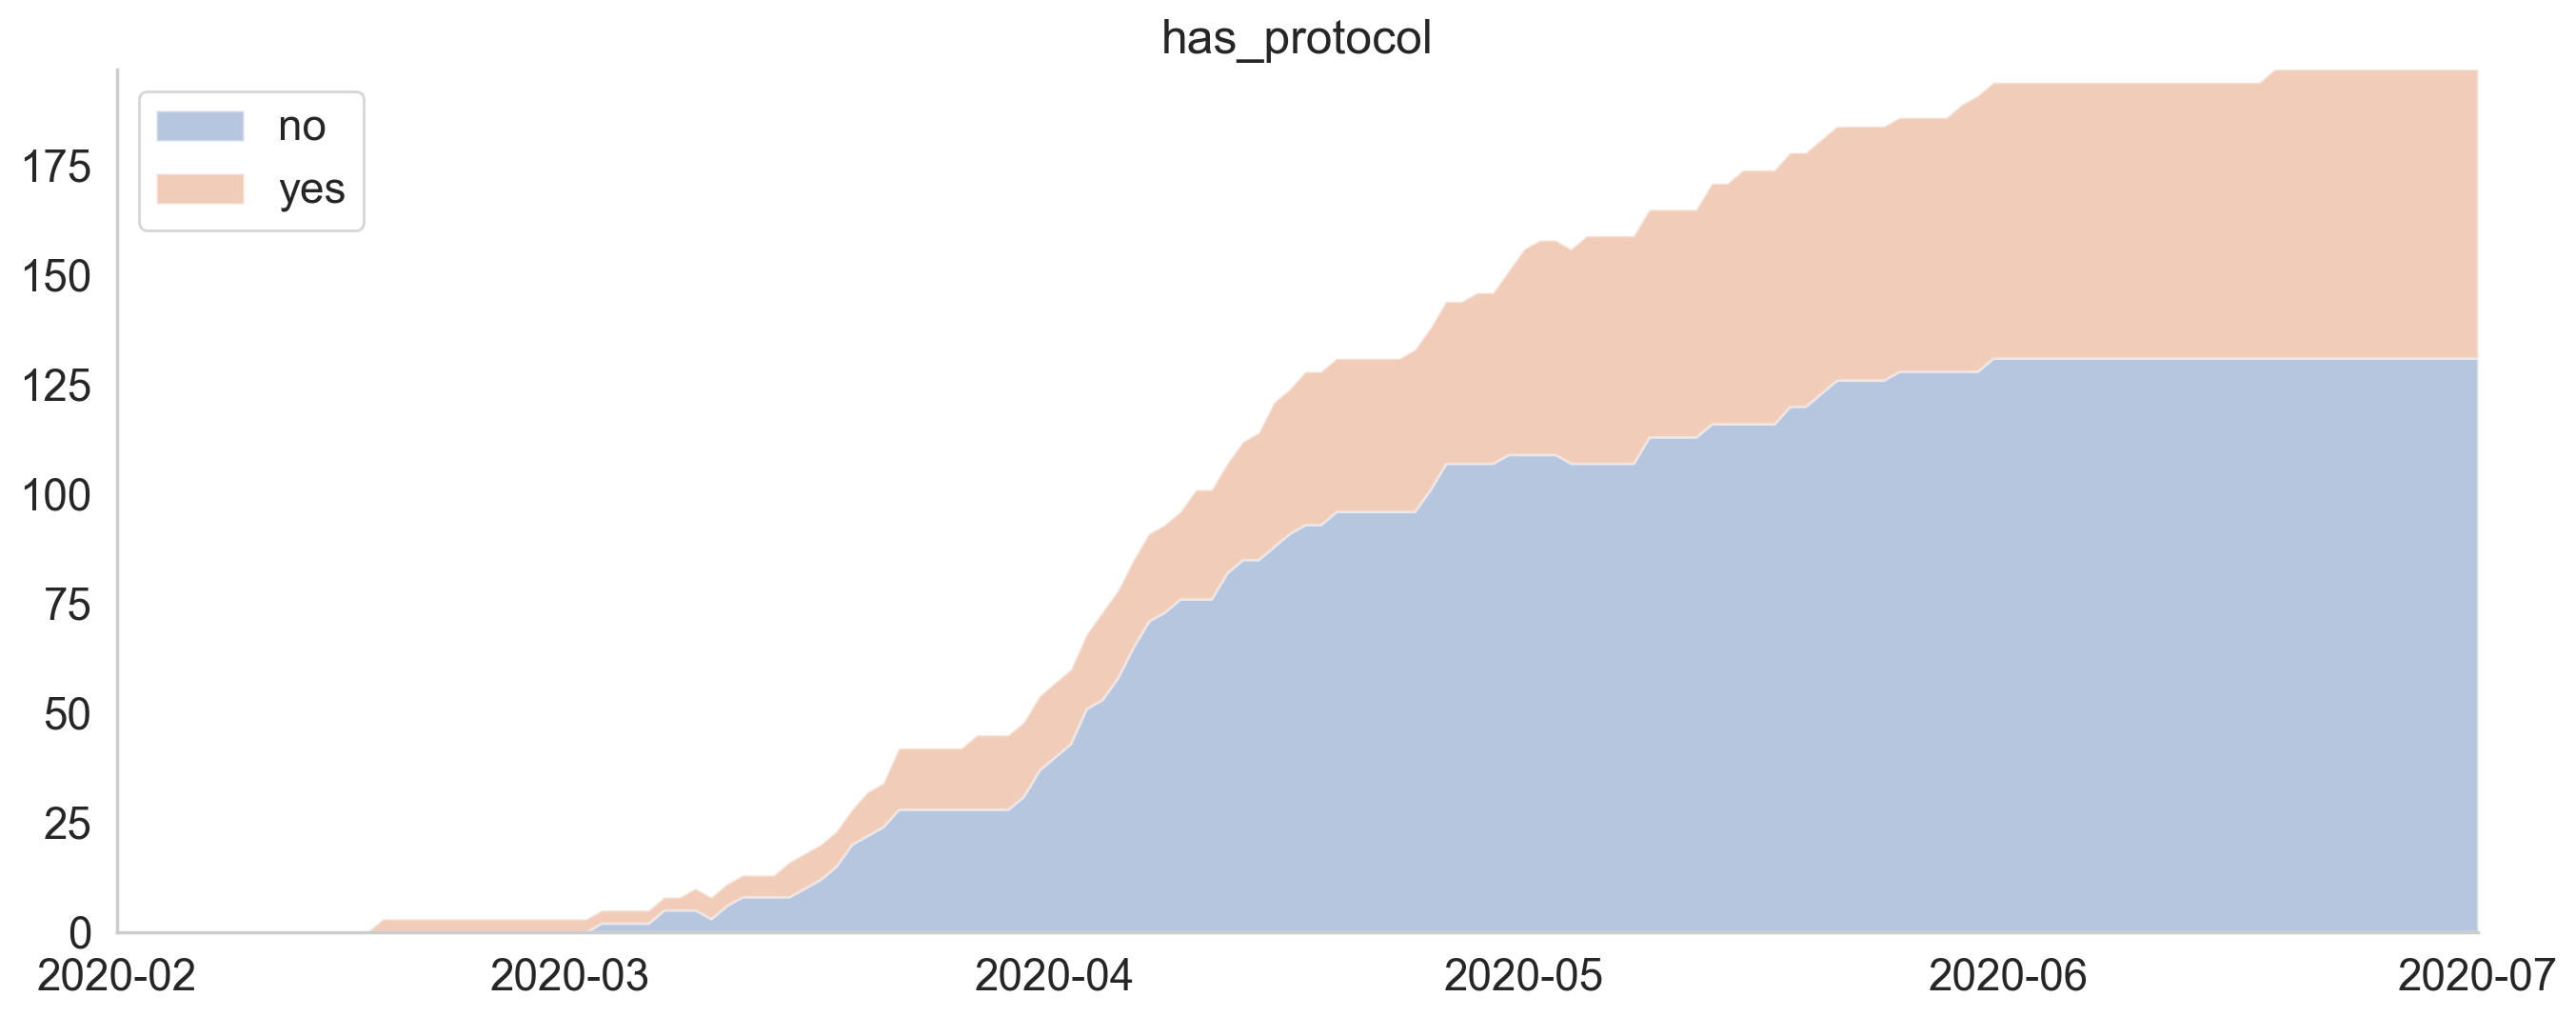

In [480]:
plot_time_series('has_protocol', status=['released', 'dev'], stacked=True, unknown='drop')

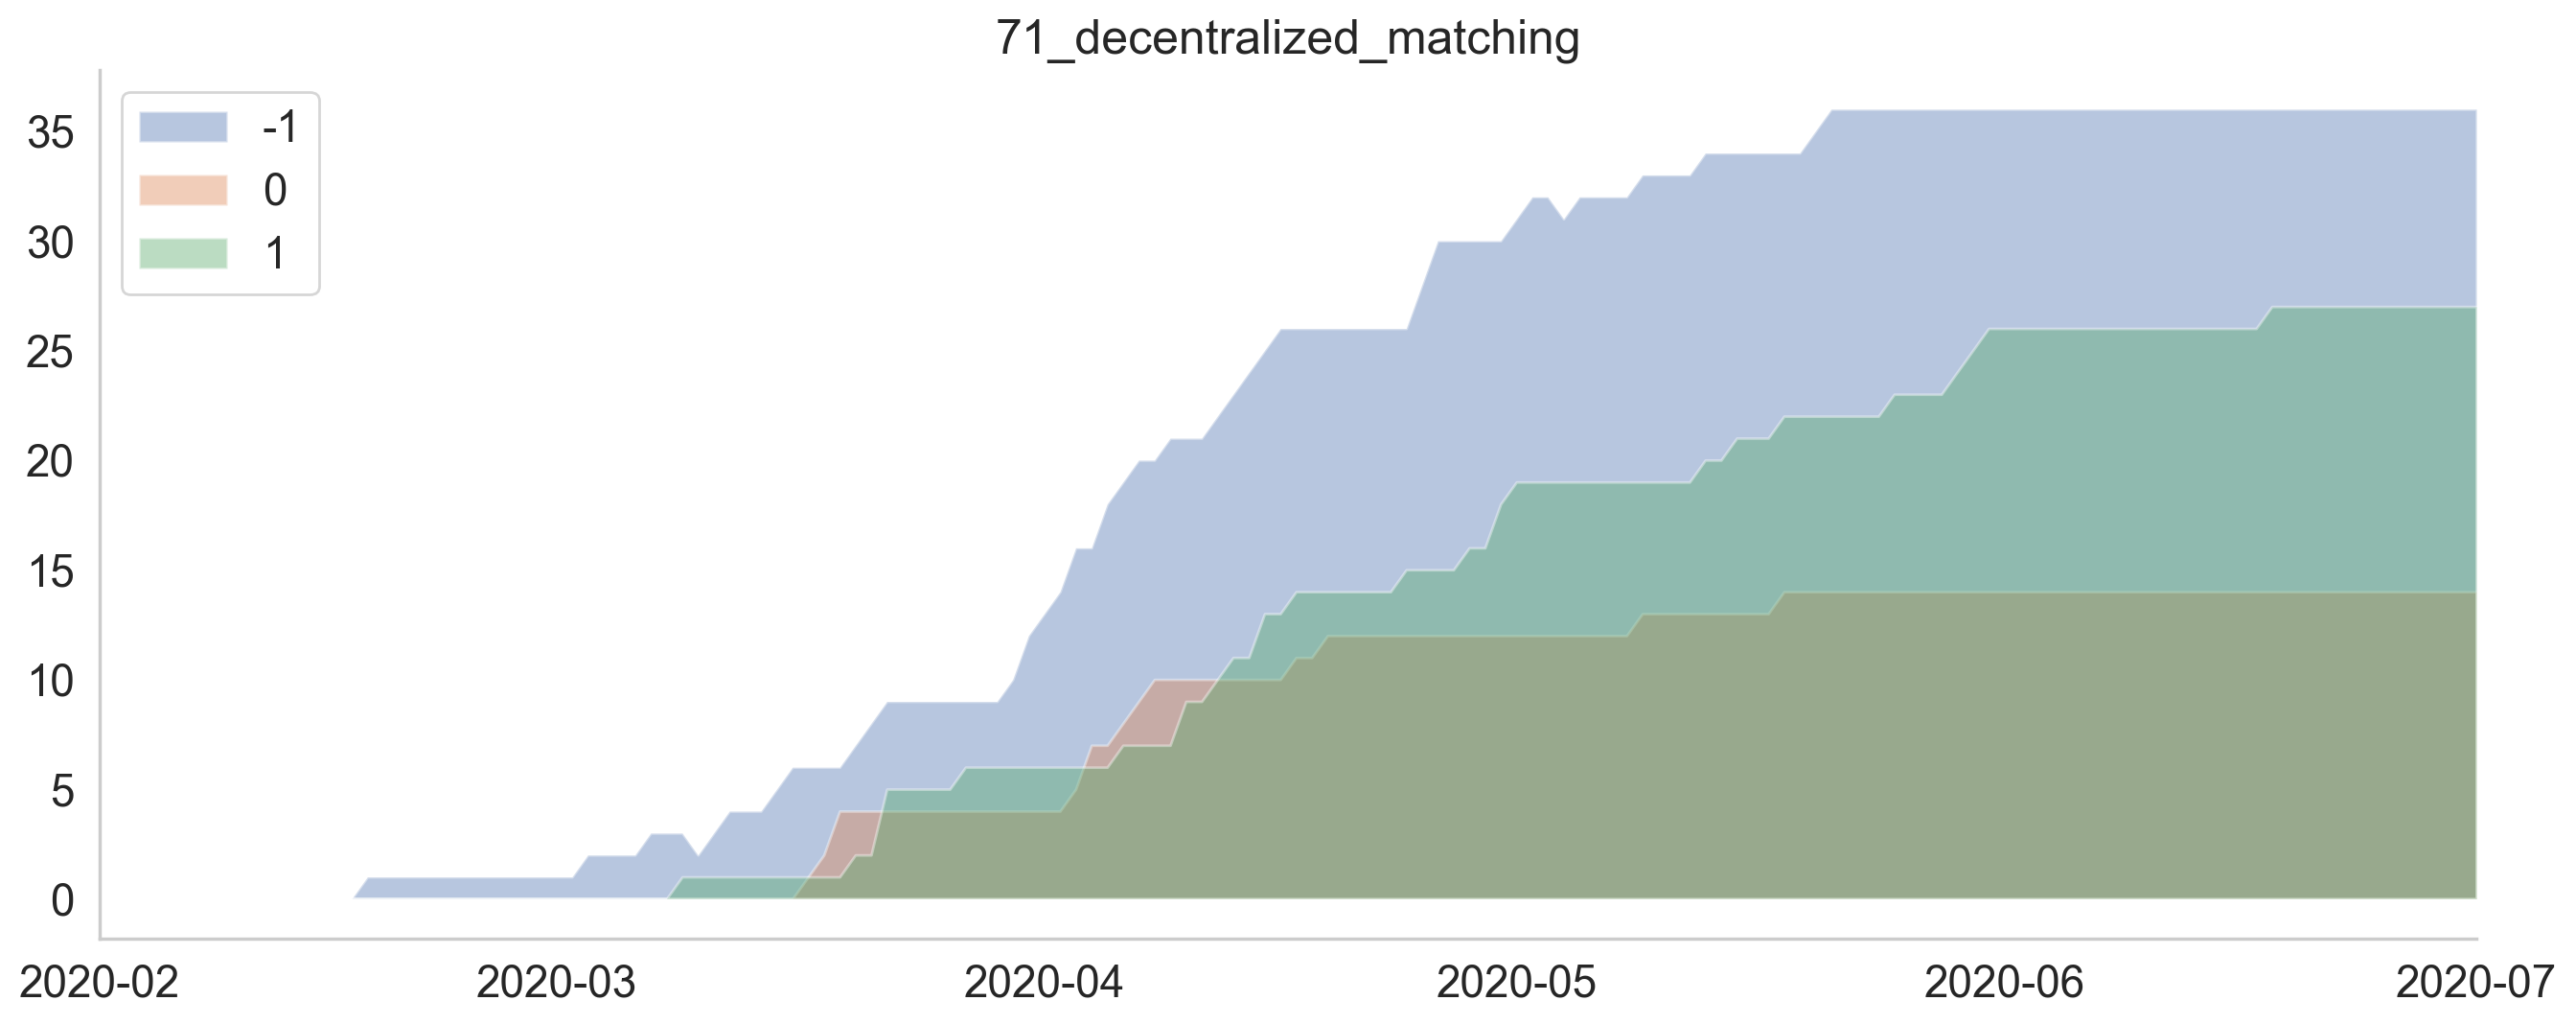

In [229]:
plot_time_series('71_decentralized_matching', status=['released', 'dev'], stacked=False, unknown='drop')

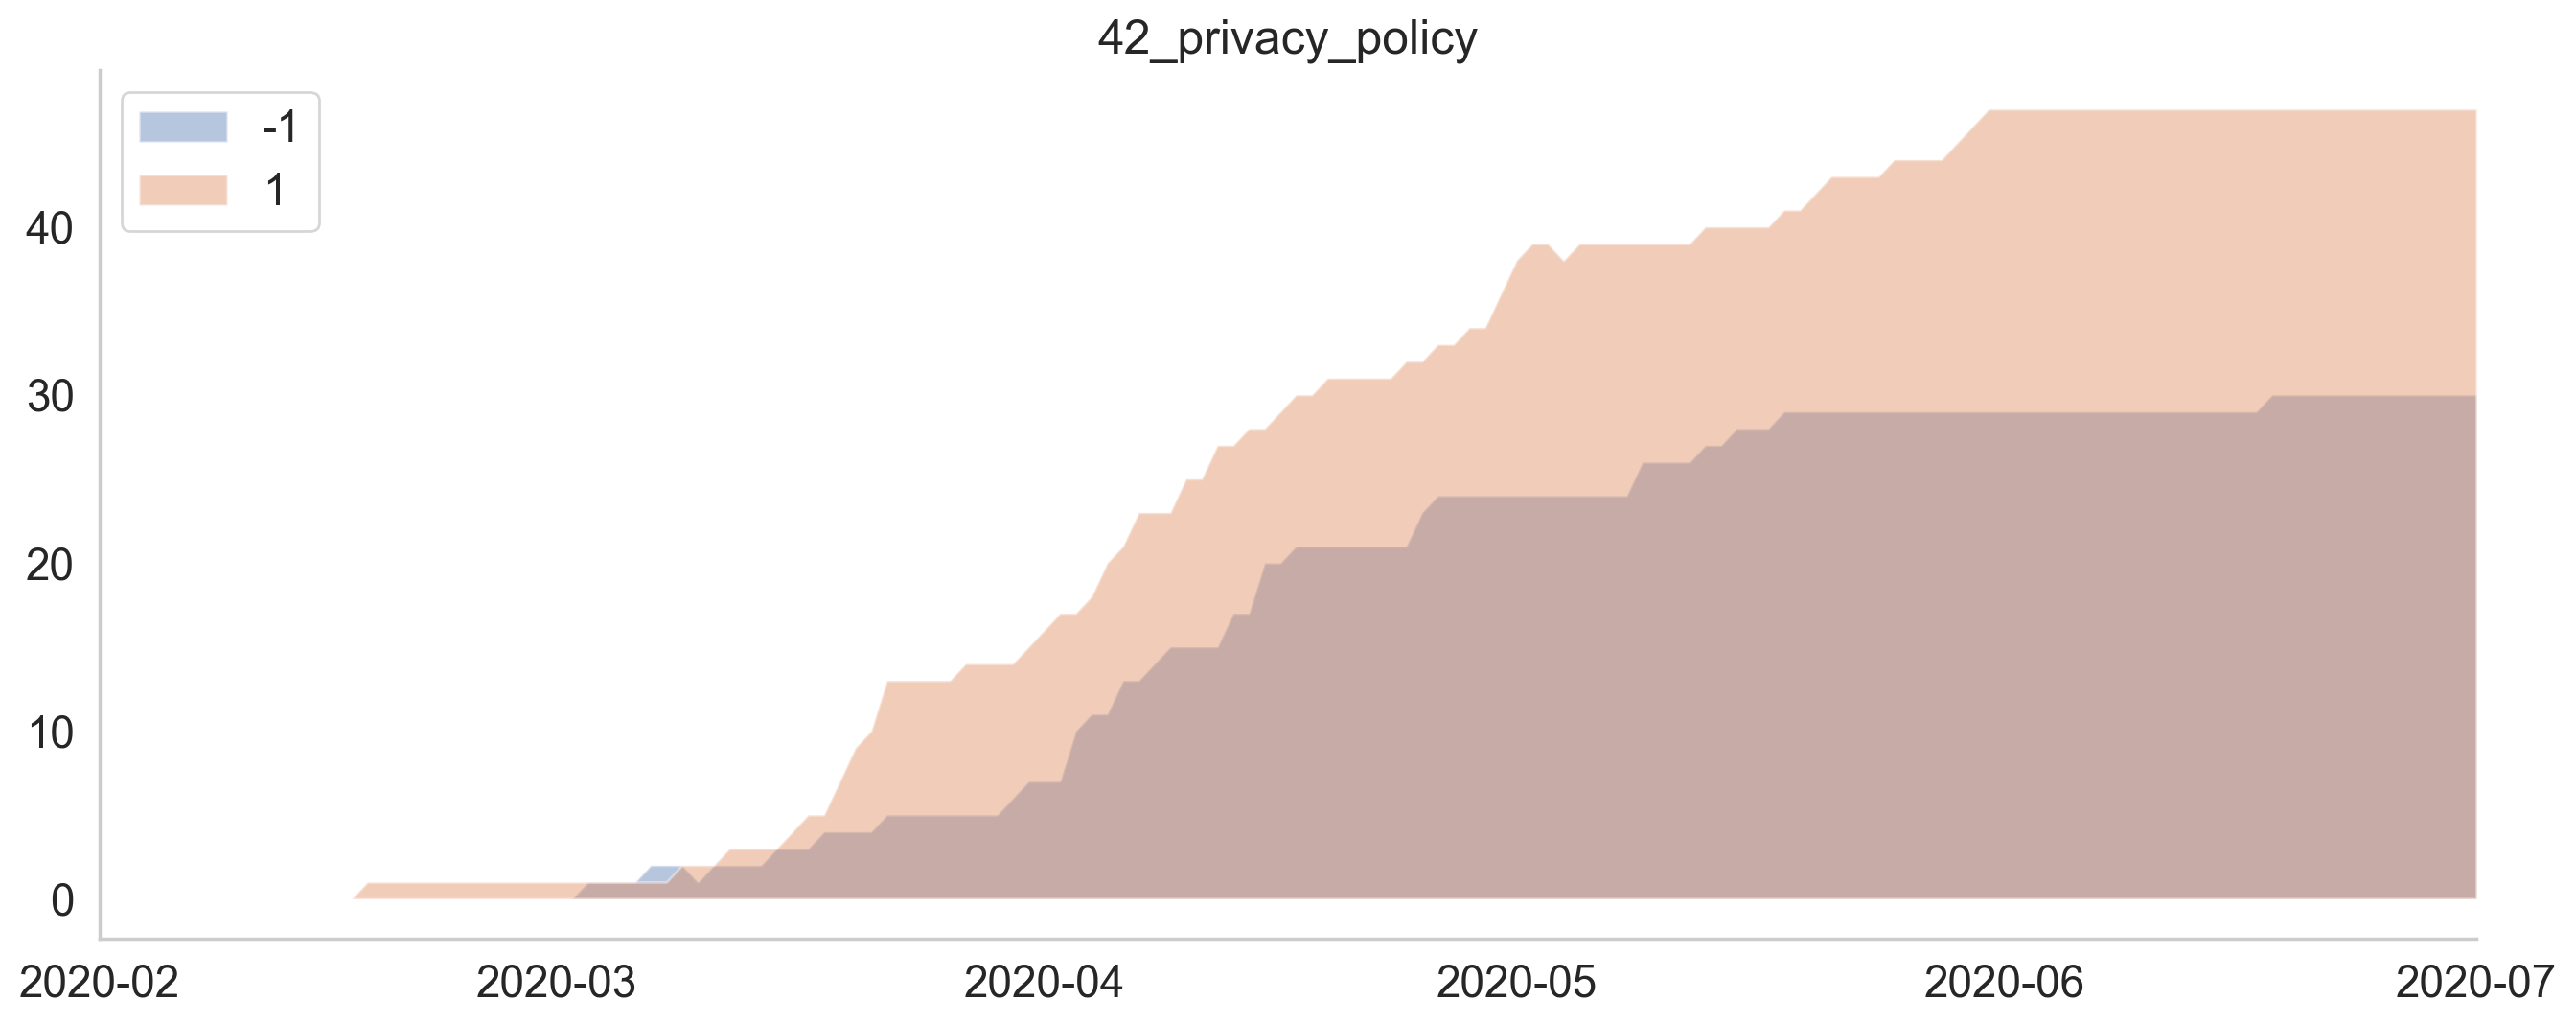

In [228]:
plot_time_series('42_privacy_policy', status=['released', 'dev'], stacked=False, unknown='drop')

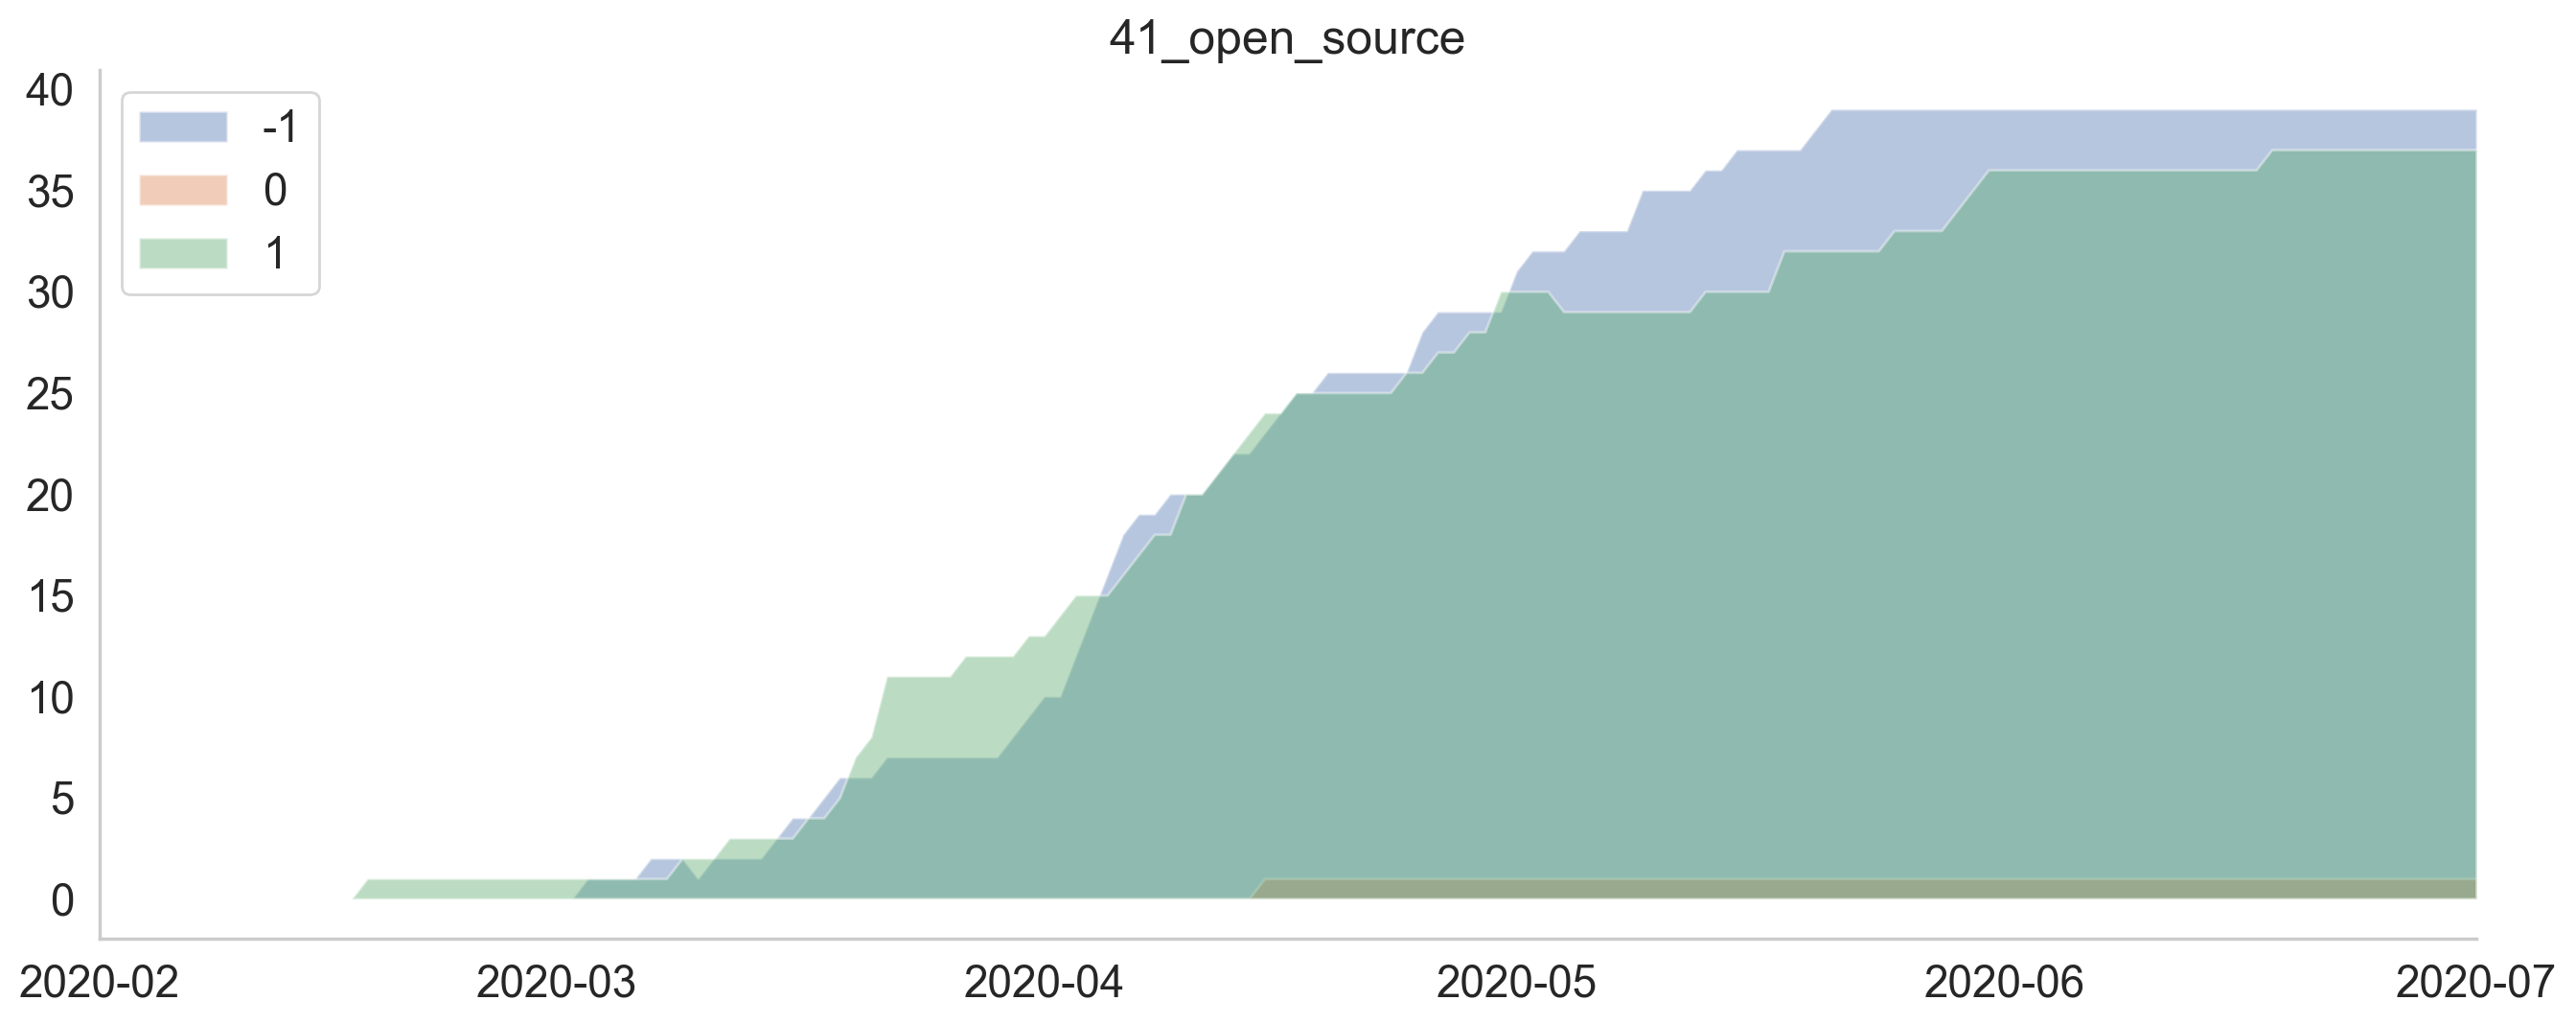

In [227]:
plot_time_series('41_open_source', status=['released', 'dev'], stacked=False, unknown='drop')

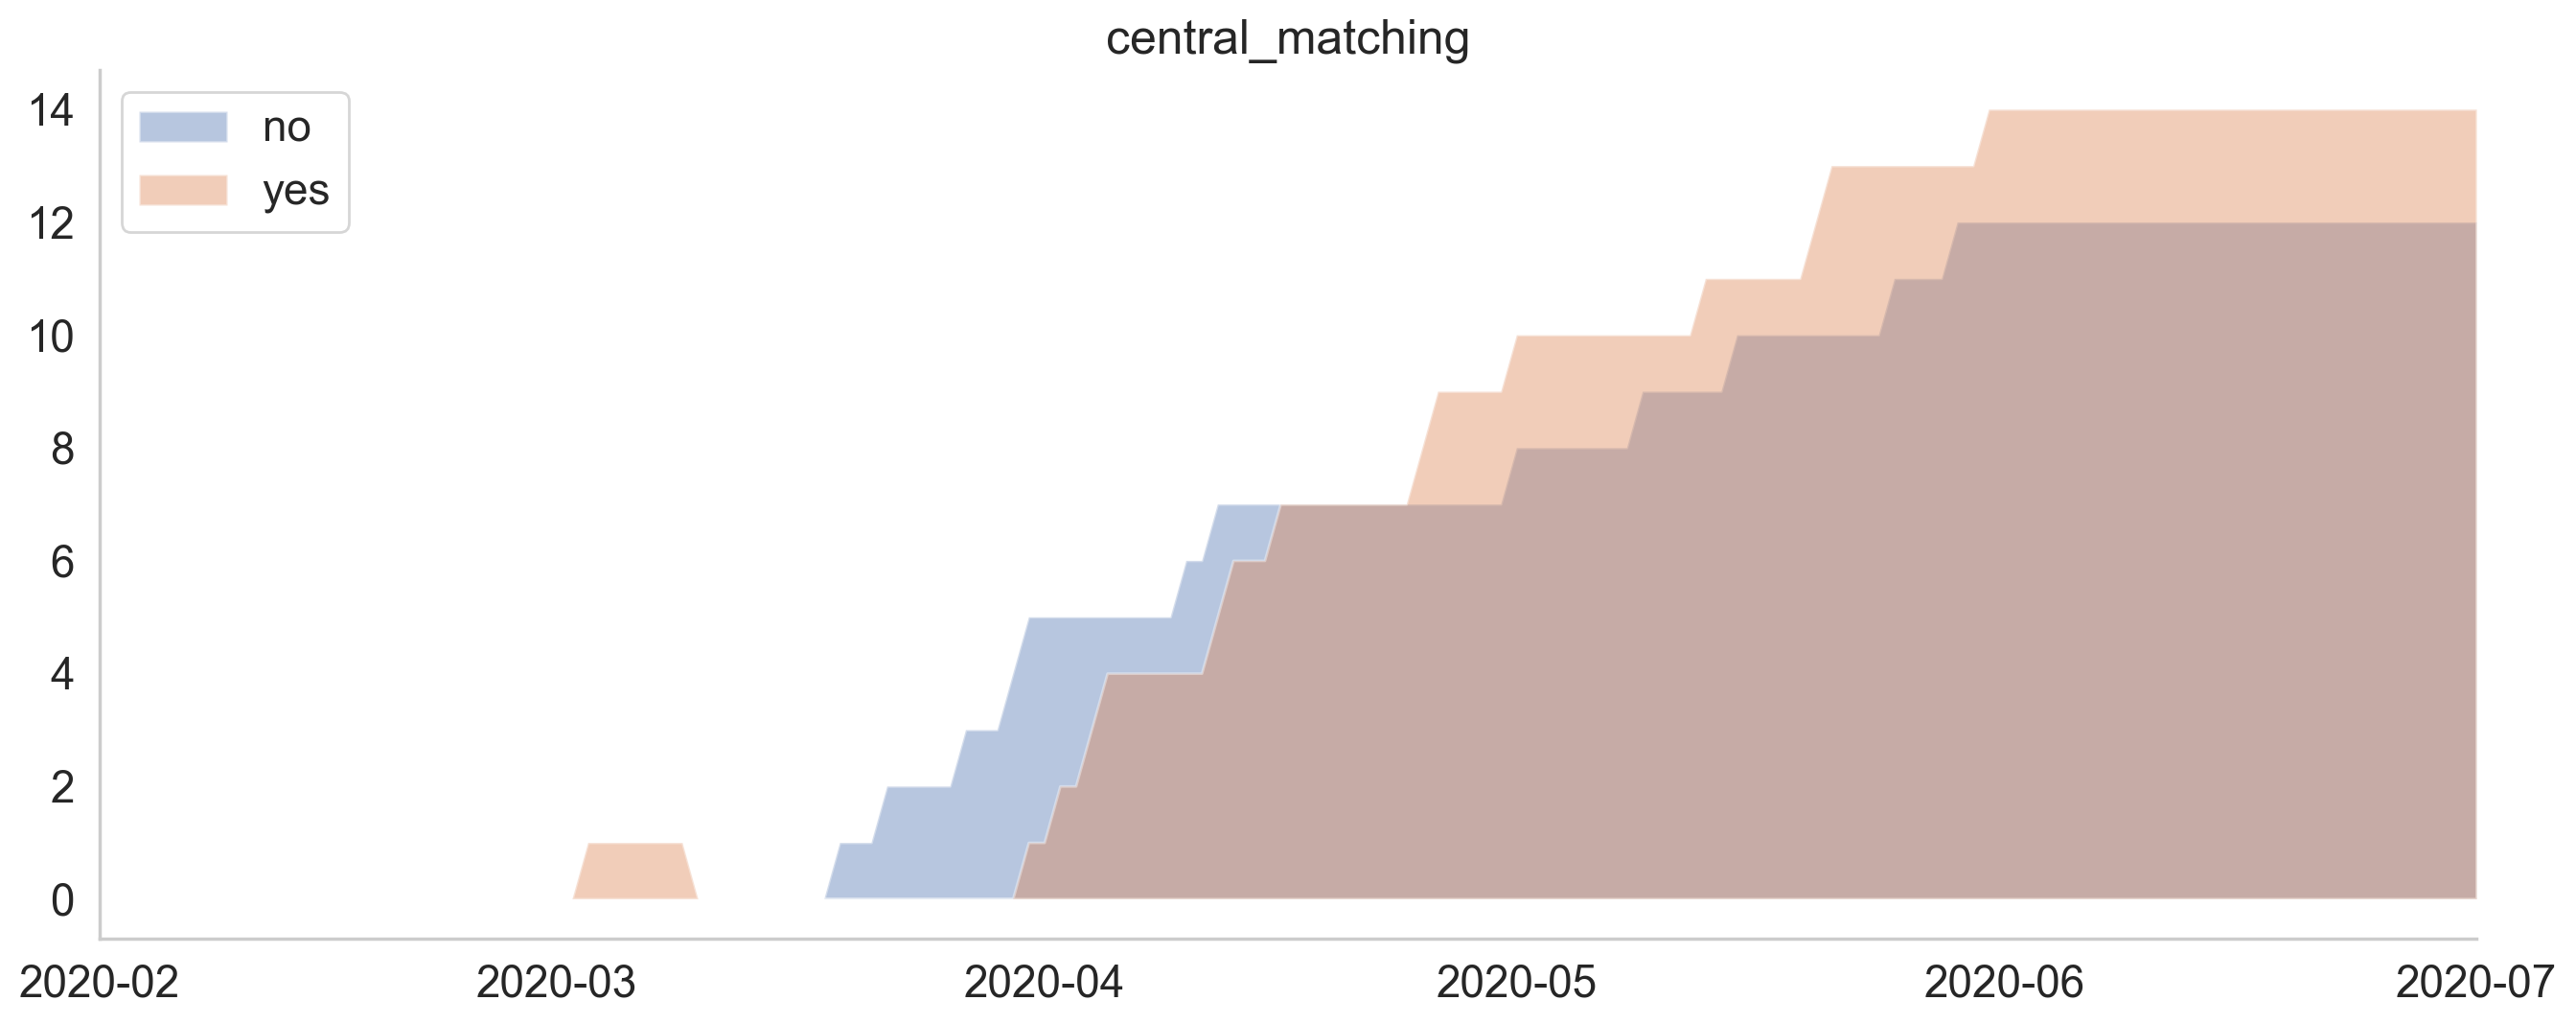

In [271]:
plot_time_series('central_matching', status='released', stacked=False, unknown='drop')

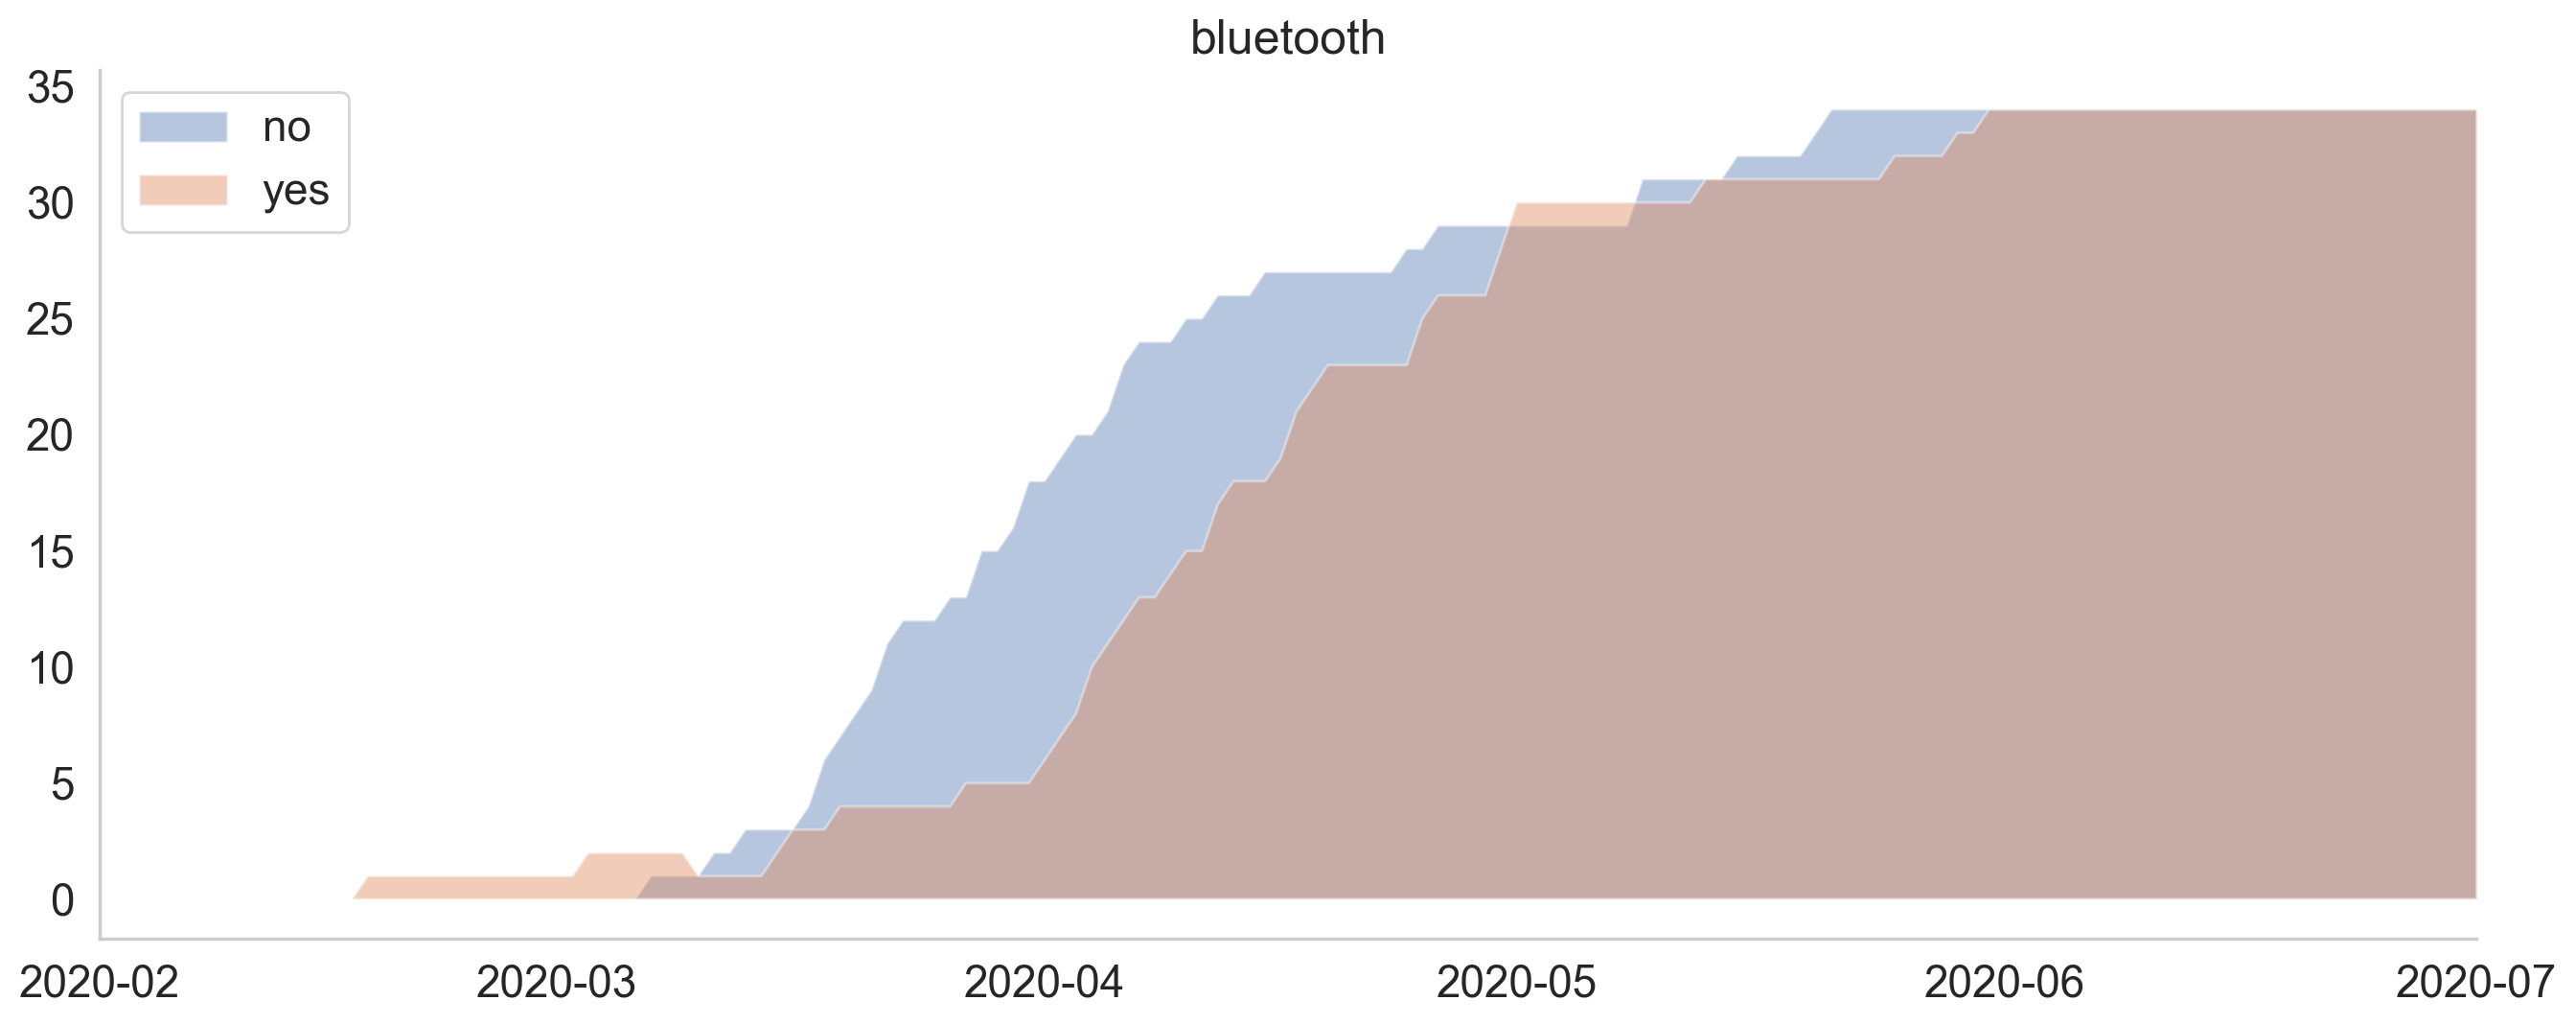

In [260]:
plot_time_series('bluetooth', unknown='no', status='released', stacked=False)

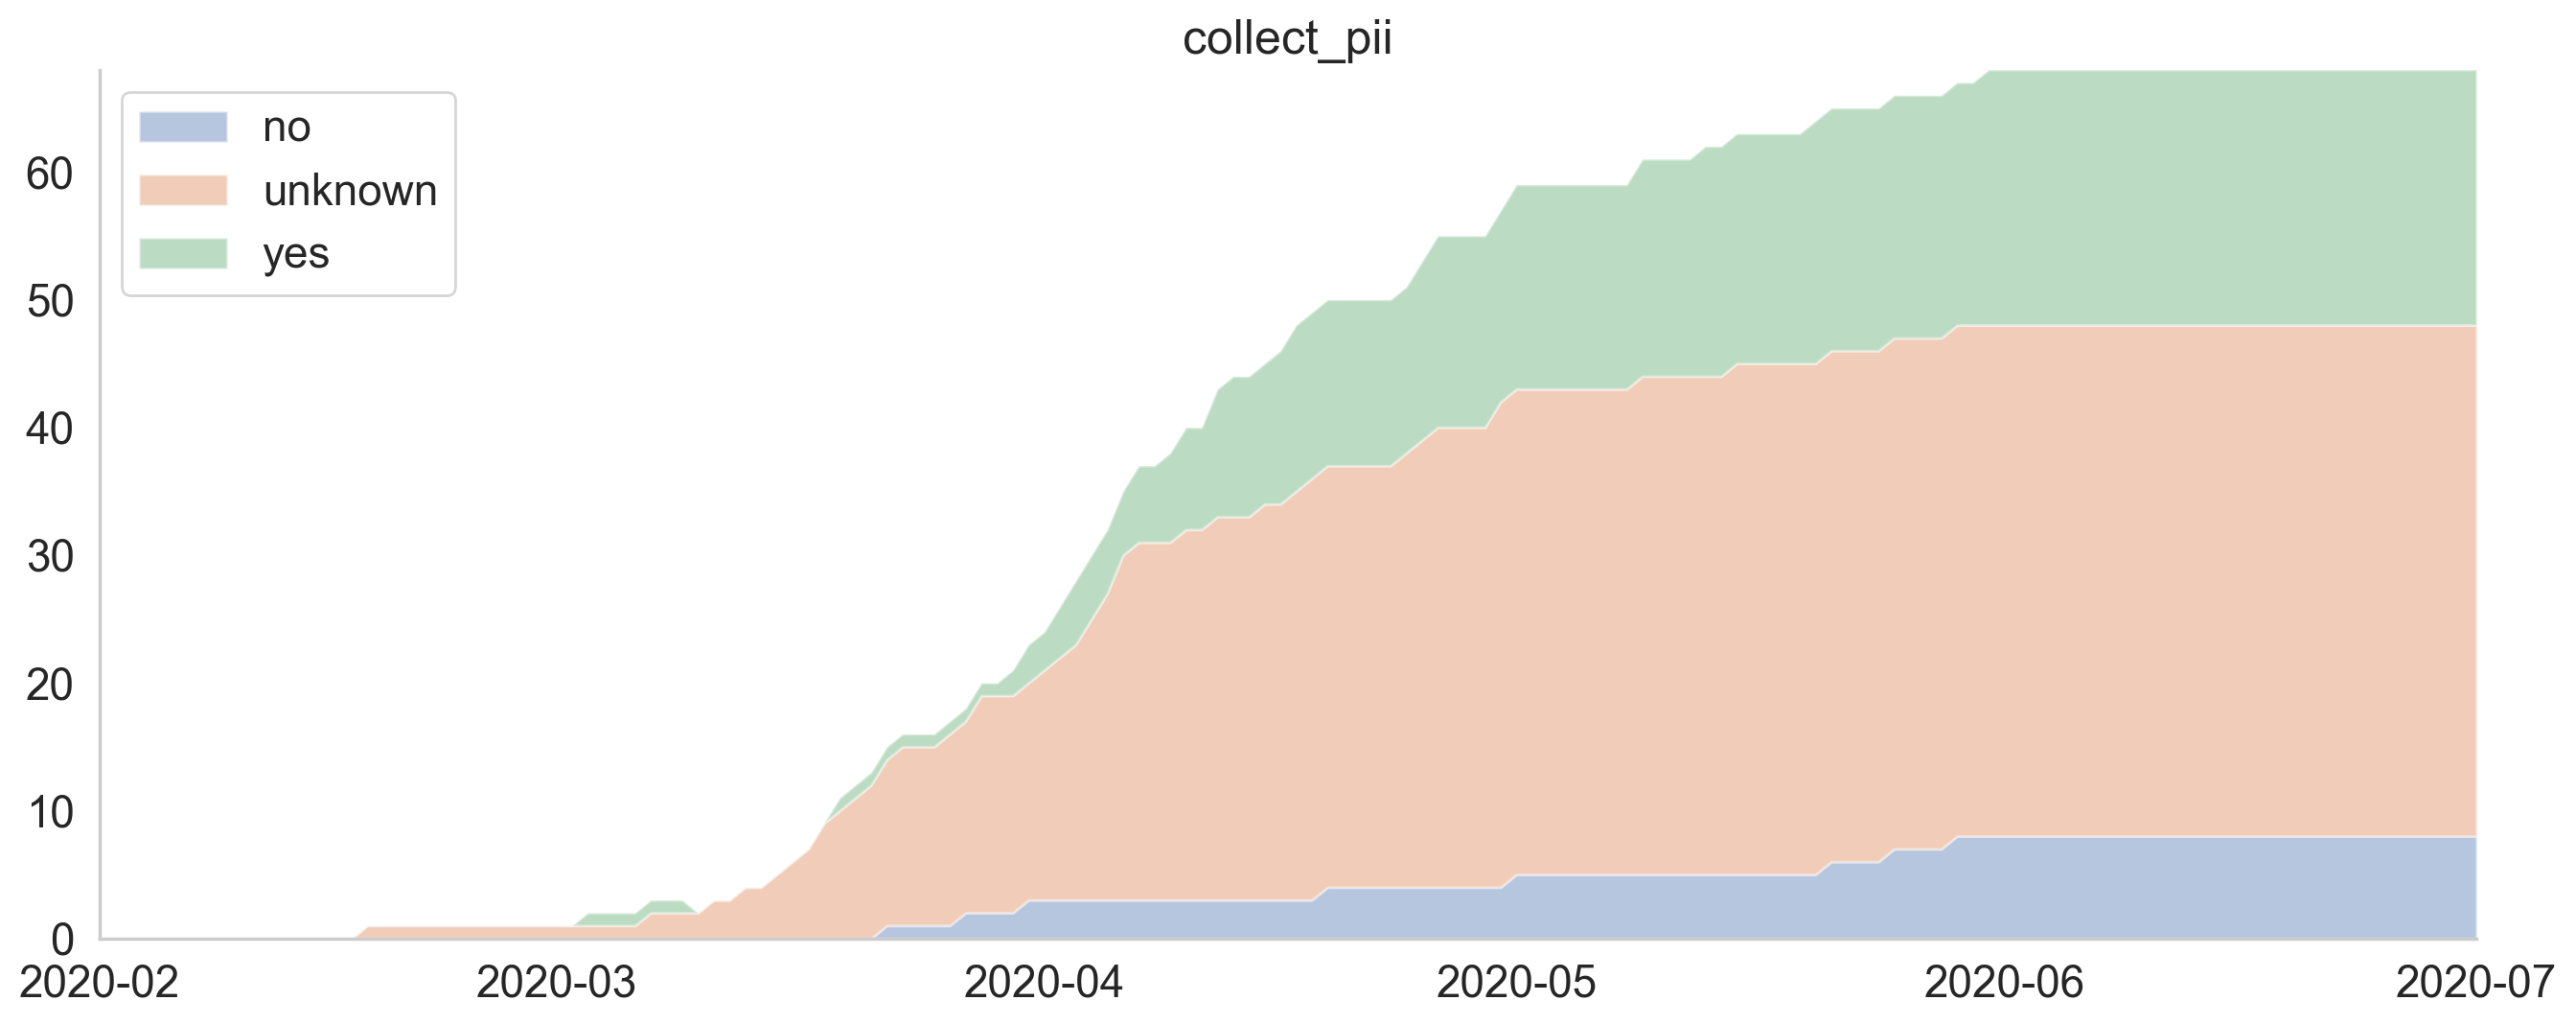

In [270]:
plot_time_series('collect_pii', status=['released'], stacked=True)

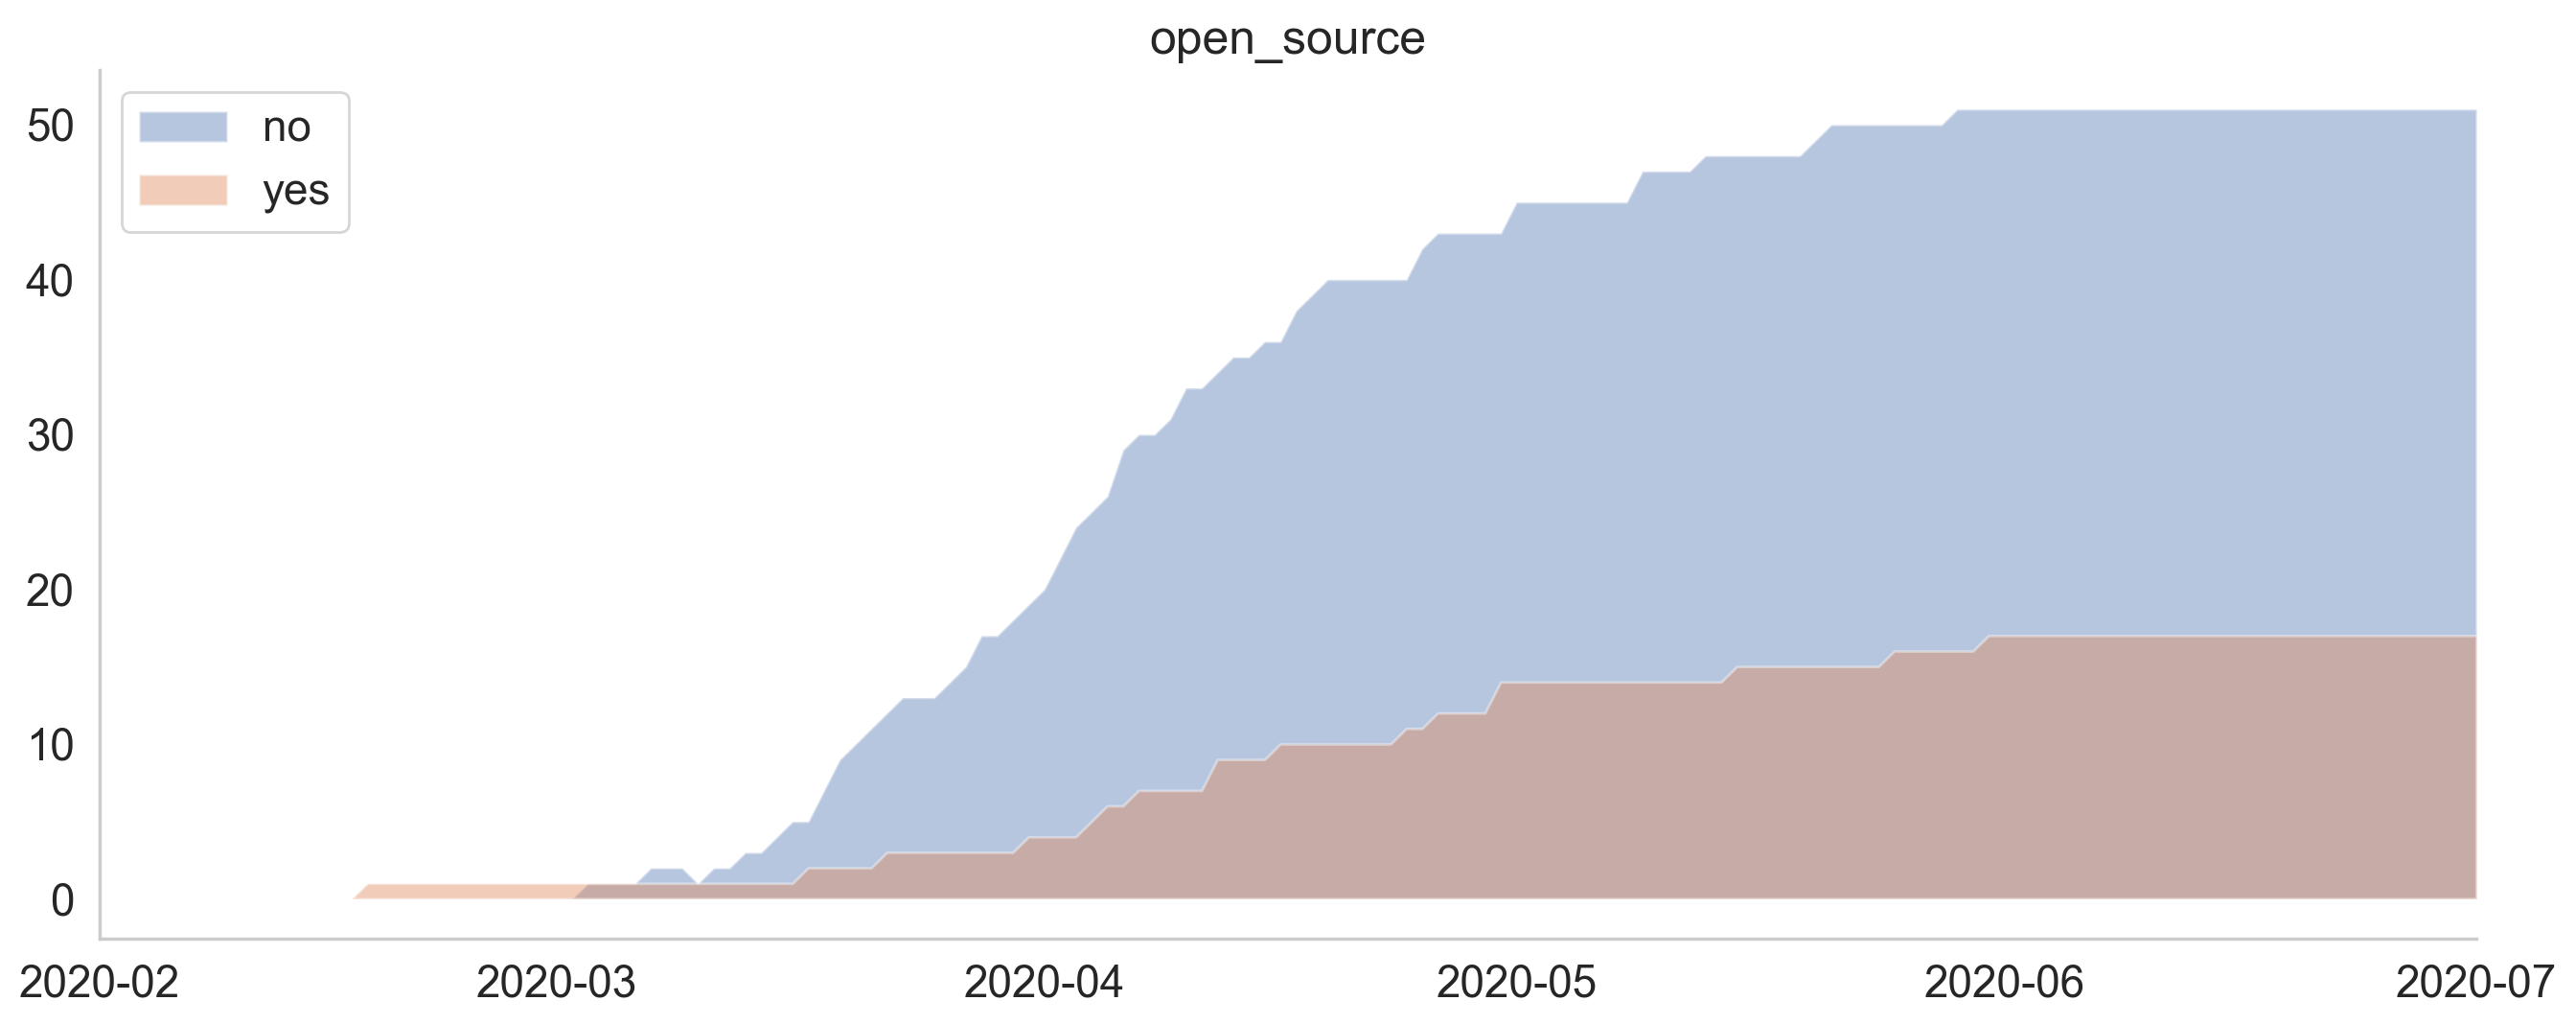

In [261]:
plot_time_series('open_source', status=['released'], stacked=False)

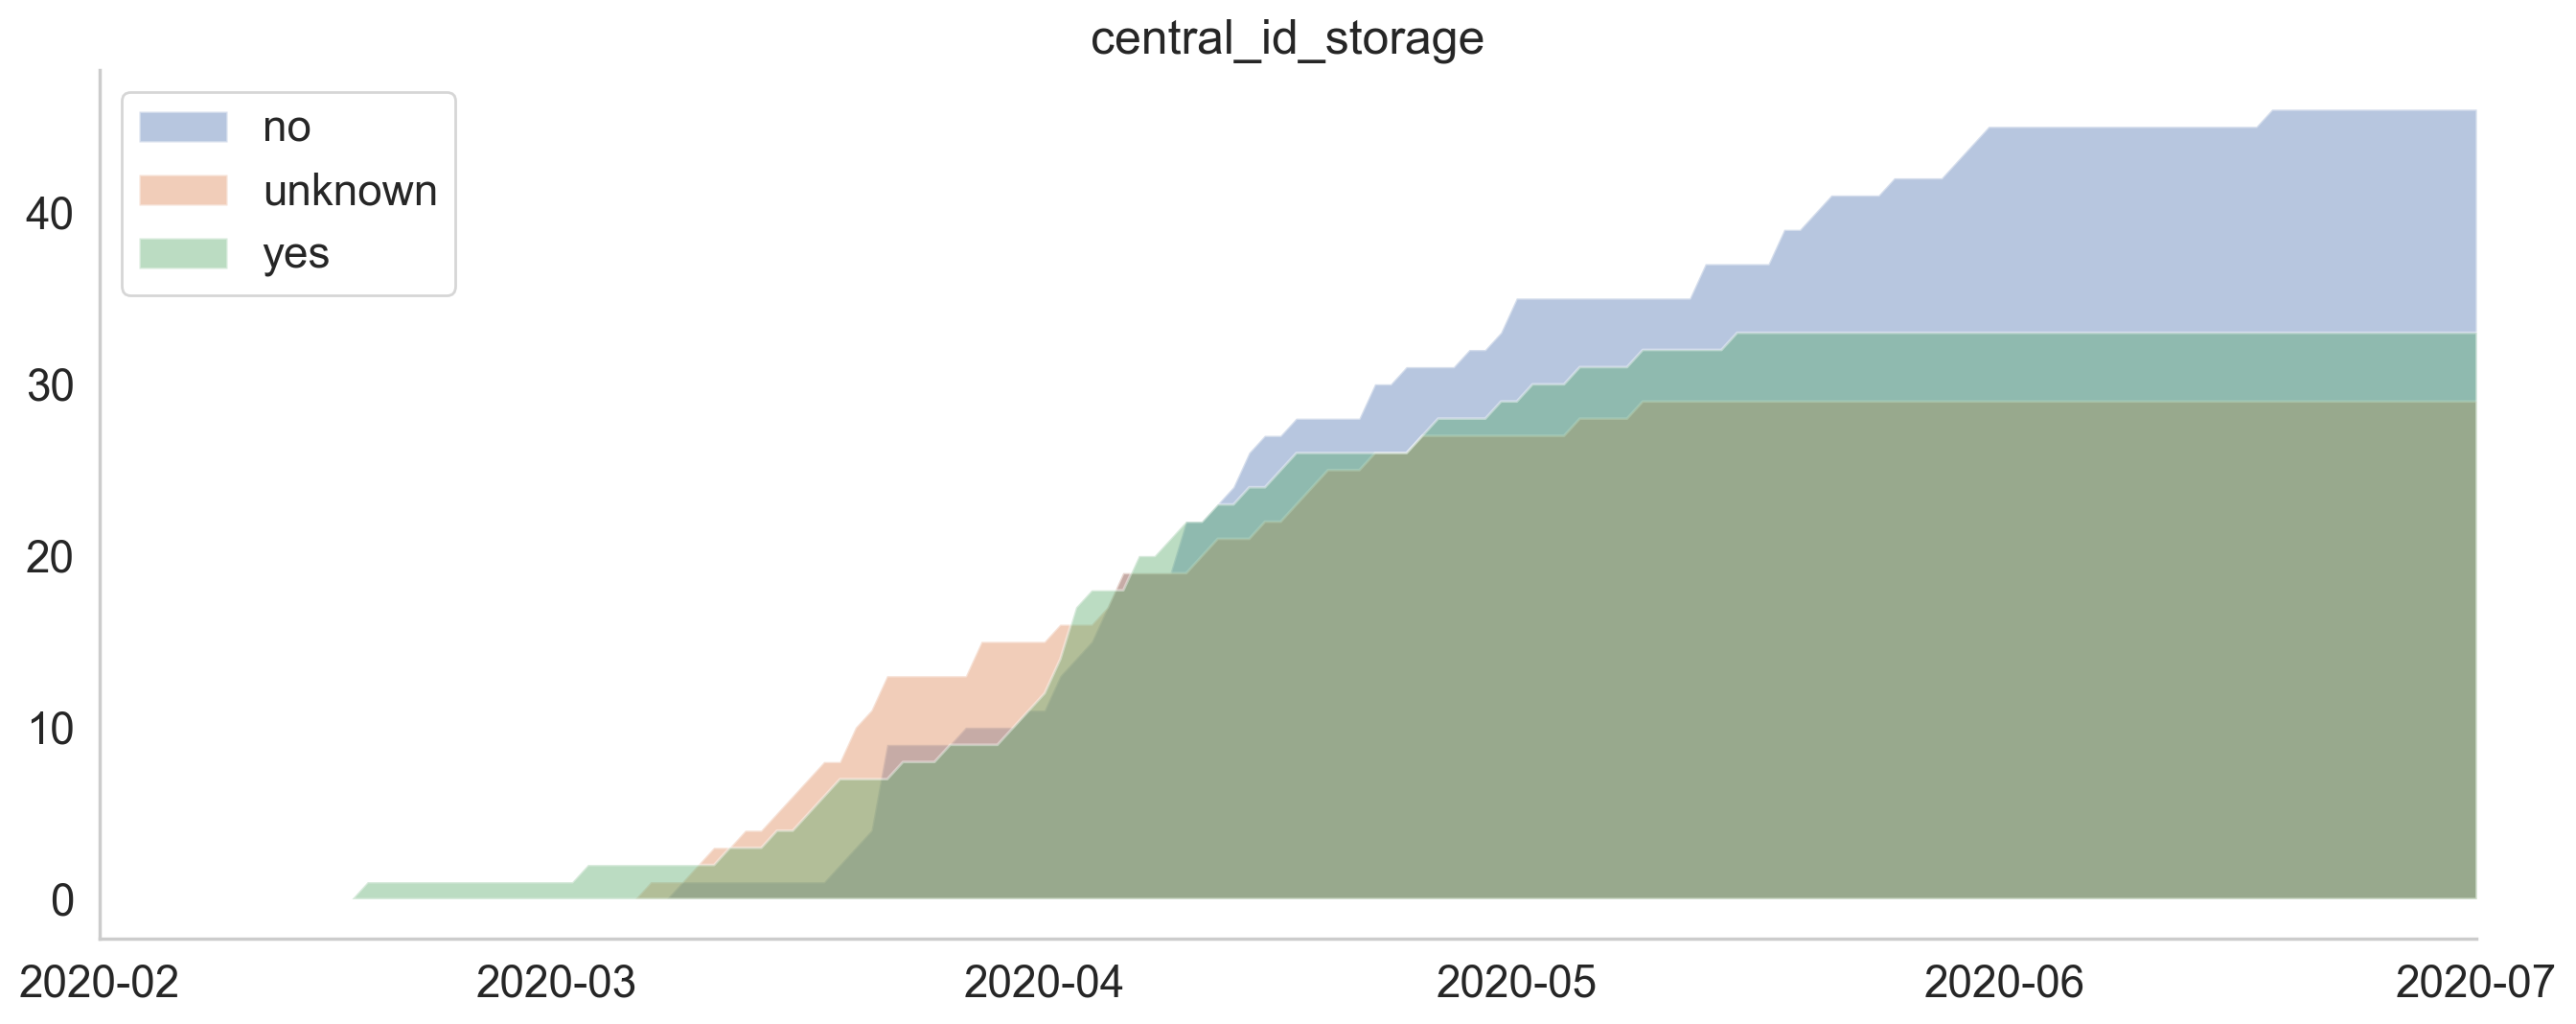

In [263]:
plot_time_series('central_id_storage', stacked=False)

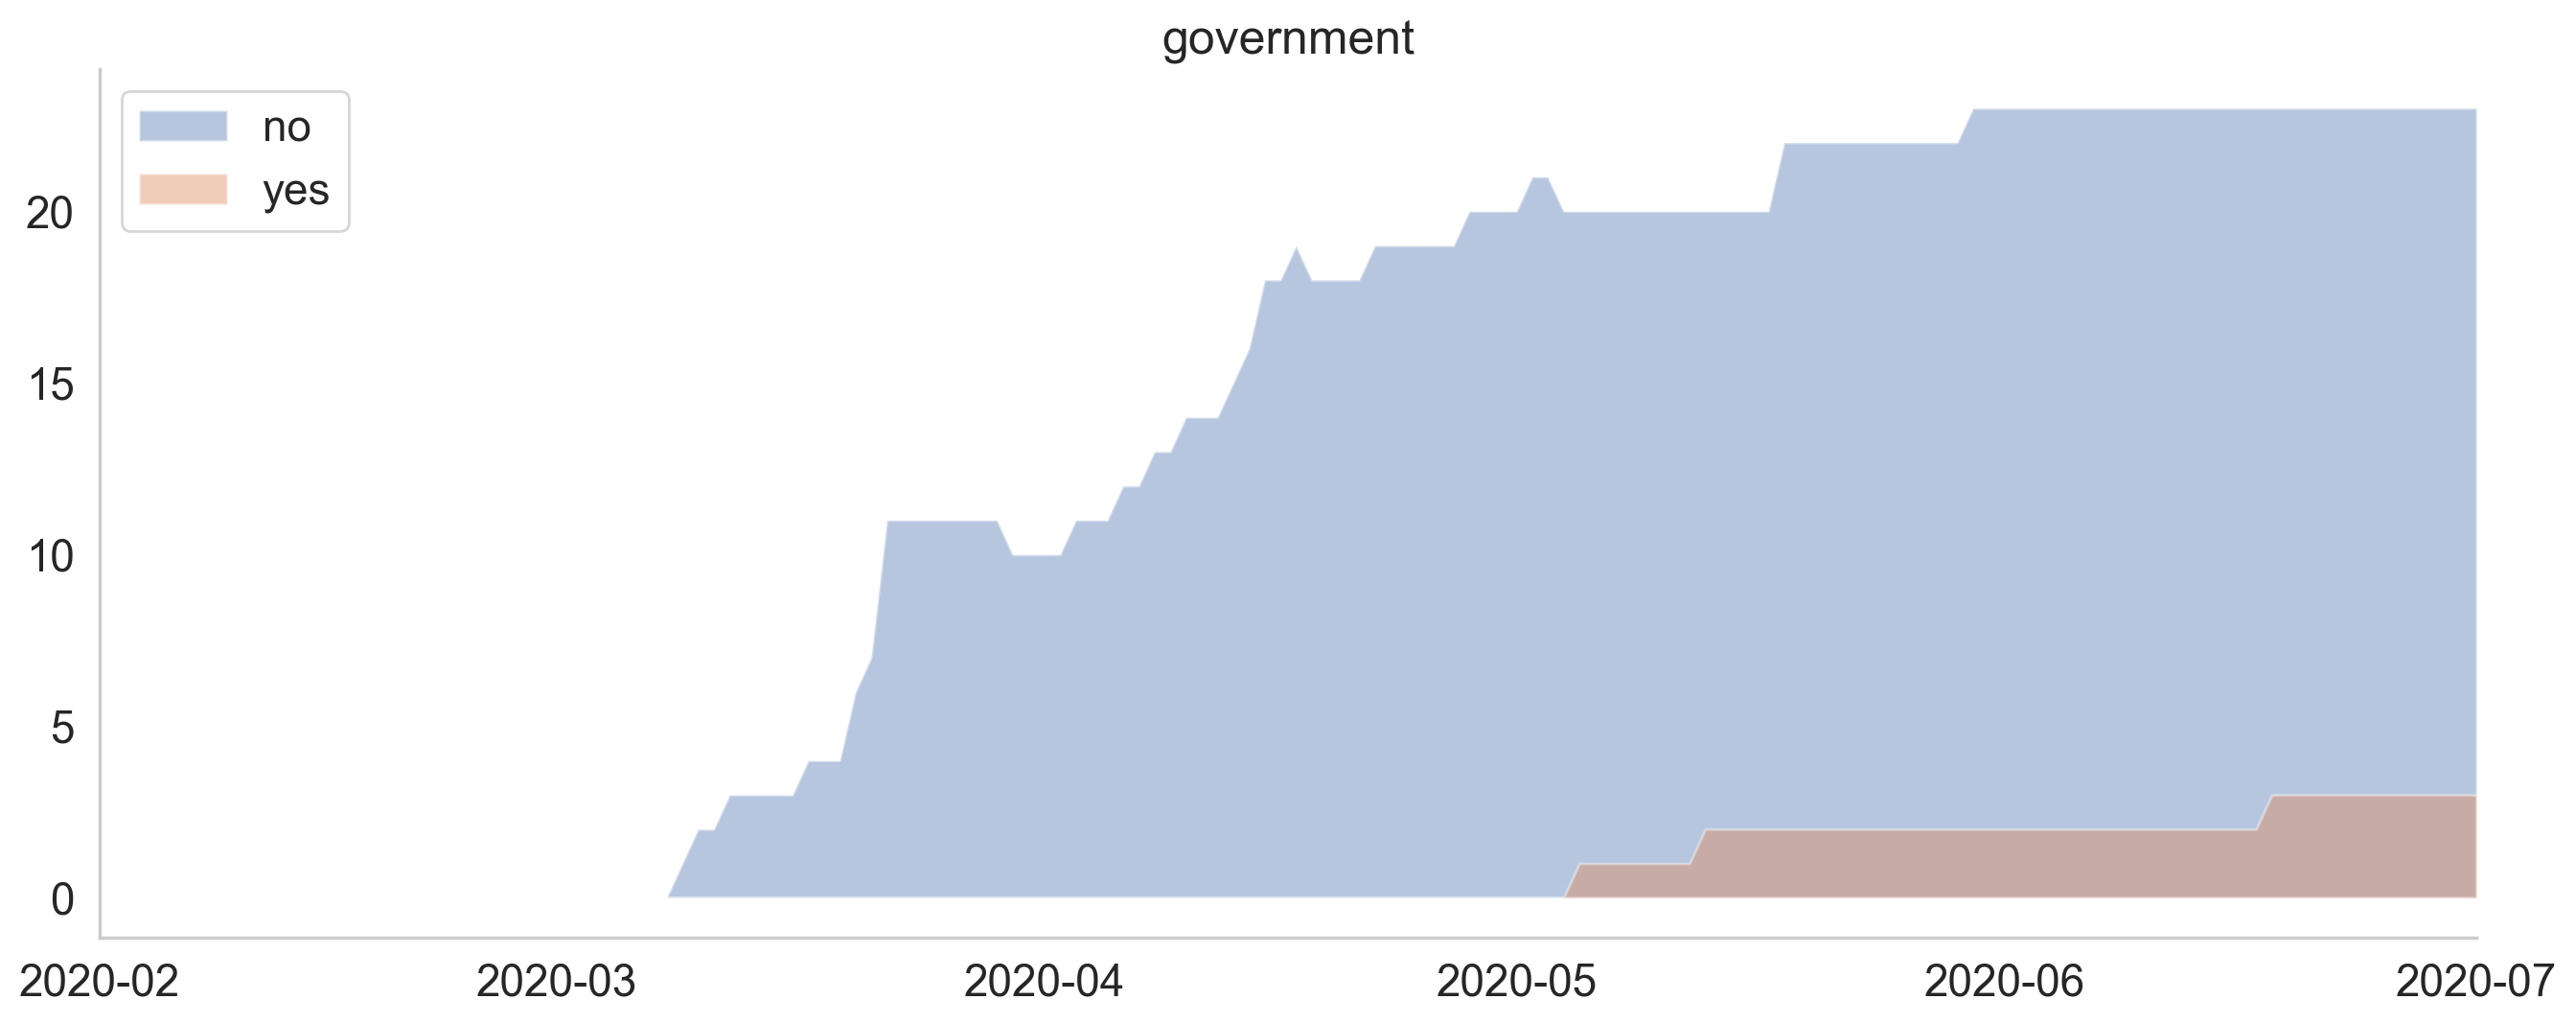

In [267]:
plot_time_series('government', unknown='no', status=['dev'], stacked=False)

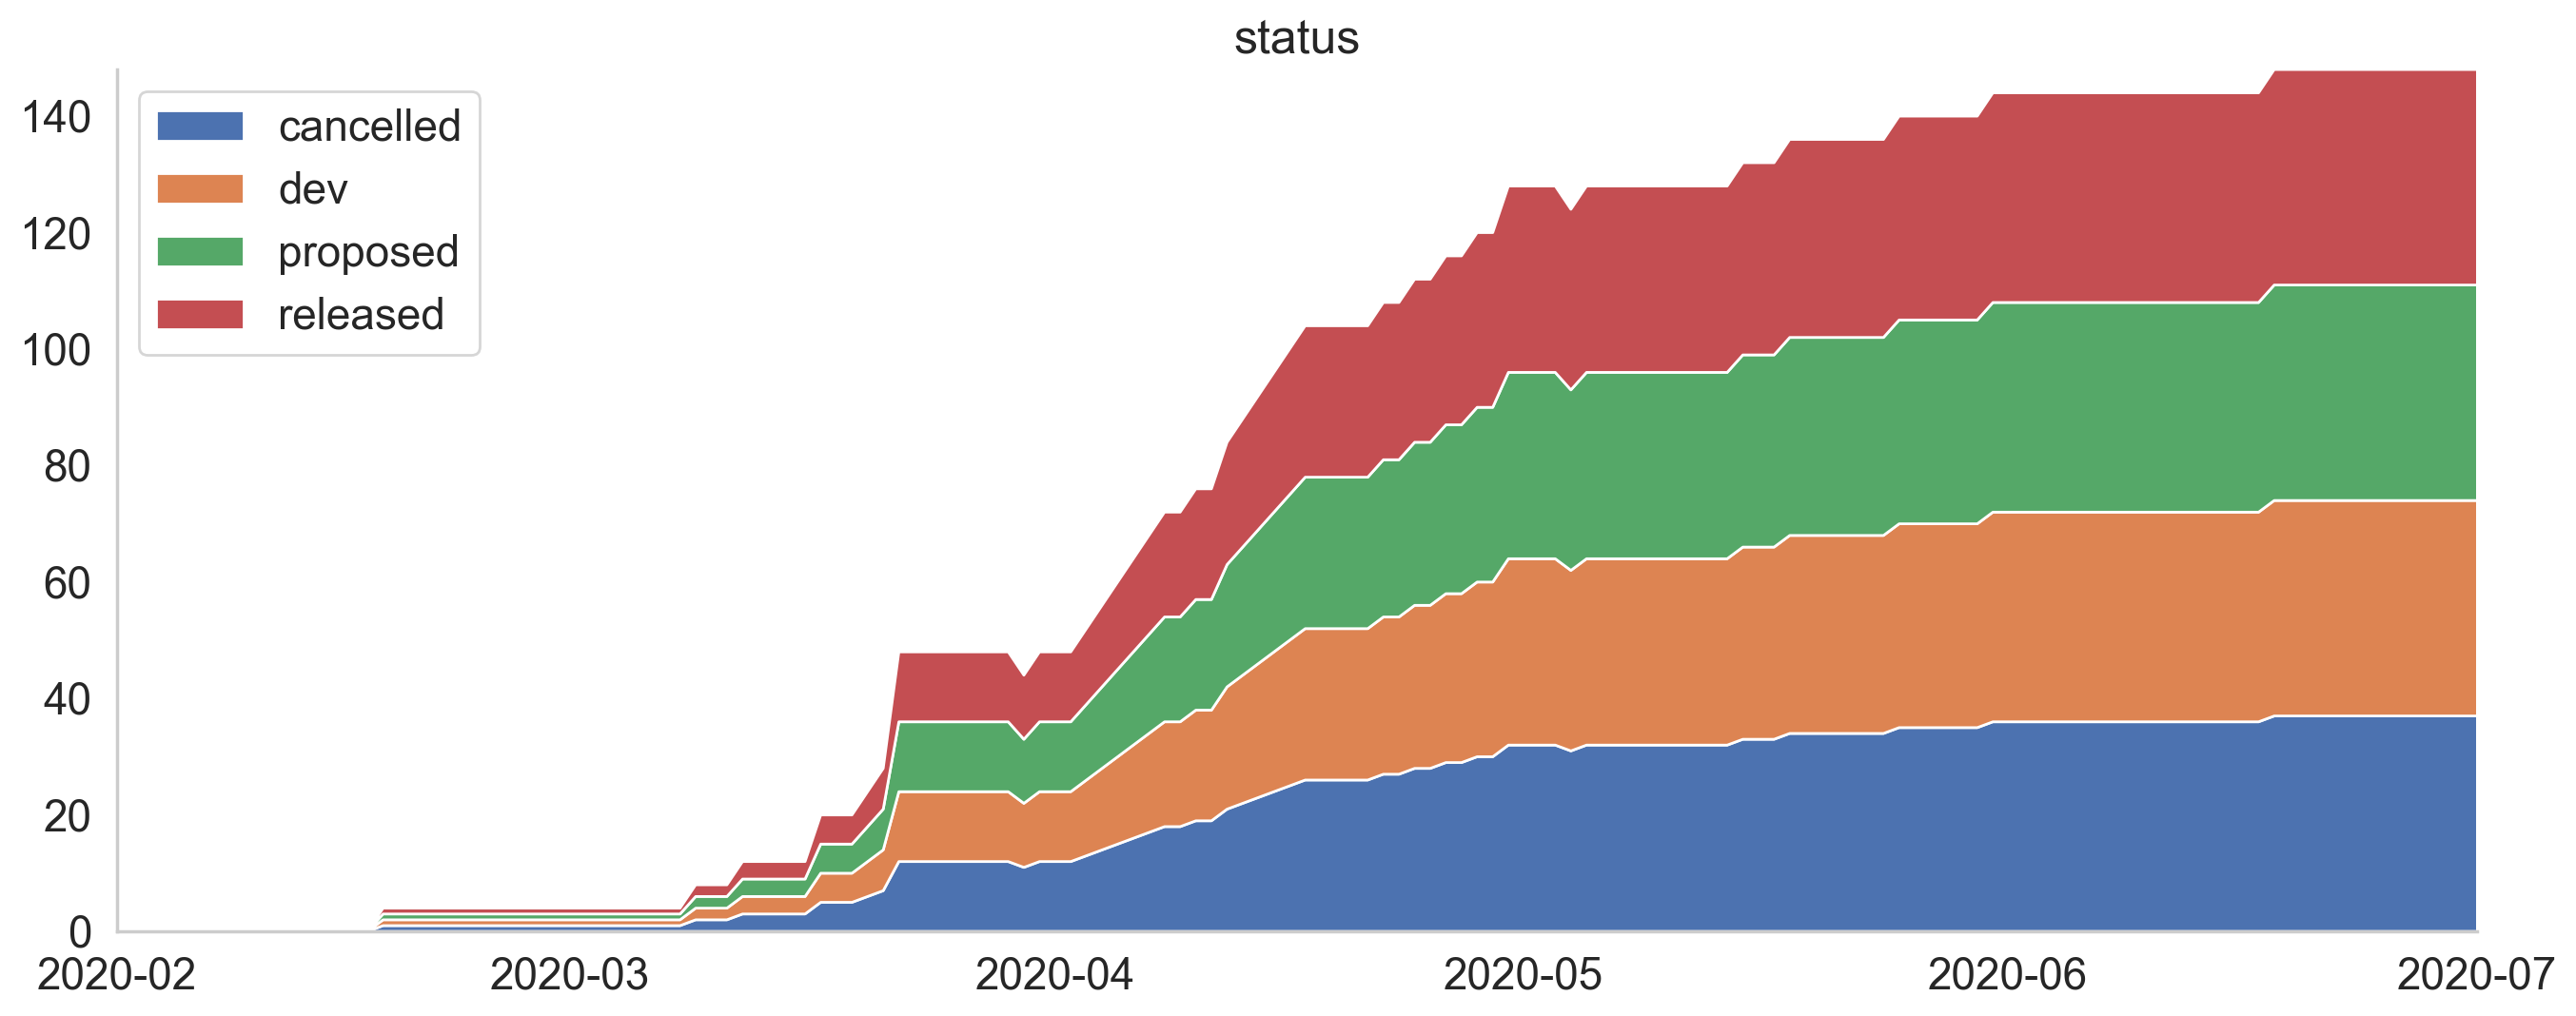

In [236]:
plot_time_series('status')

In [498]:
null_flag = ~pd.isna(df_scored['date_released'])
dates = pd.to_datetime(df_scored.loc[null_flag, 'date_released'])
firstdate = min(dates)
x = (dates - firstdate).apply(lambda x: x.days)
y = df_scored.loc[null_flag, 'score']

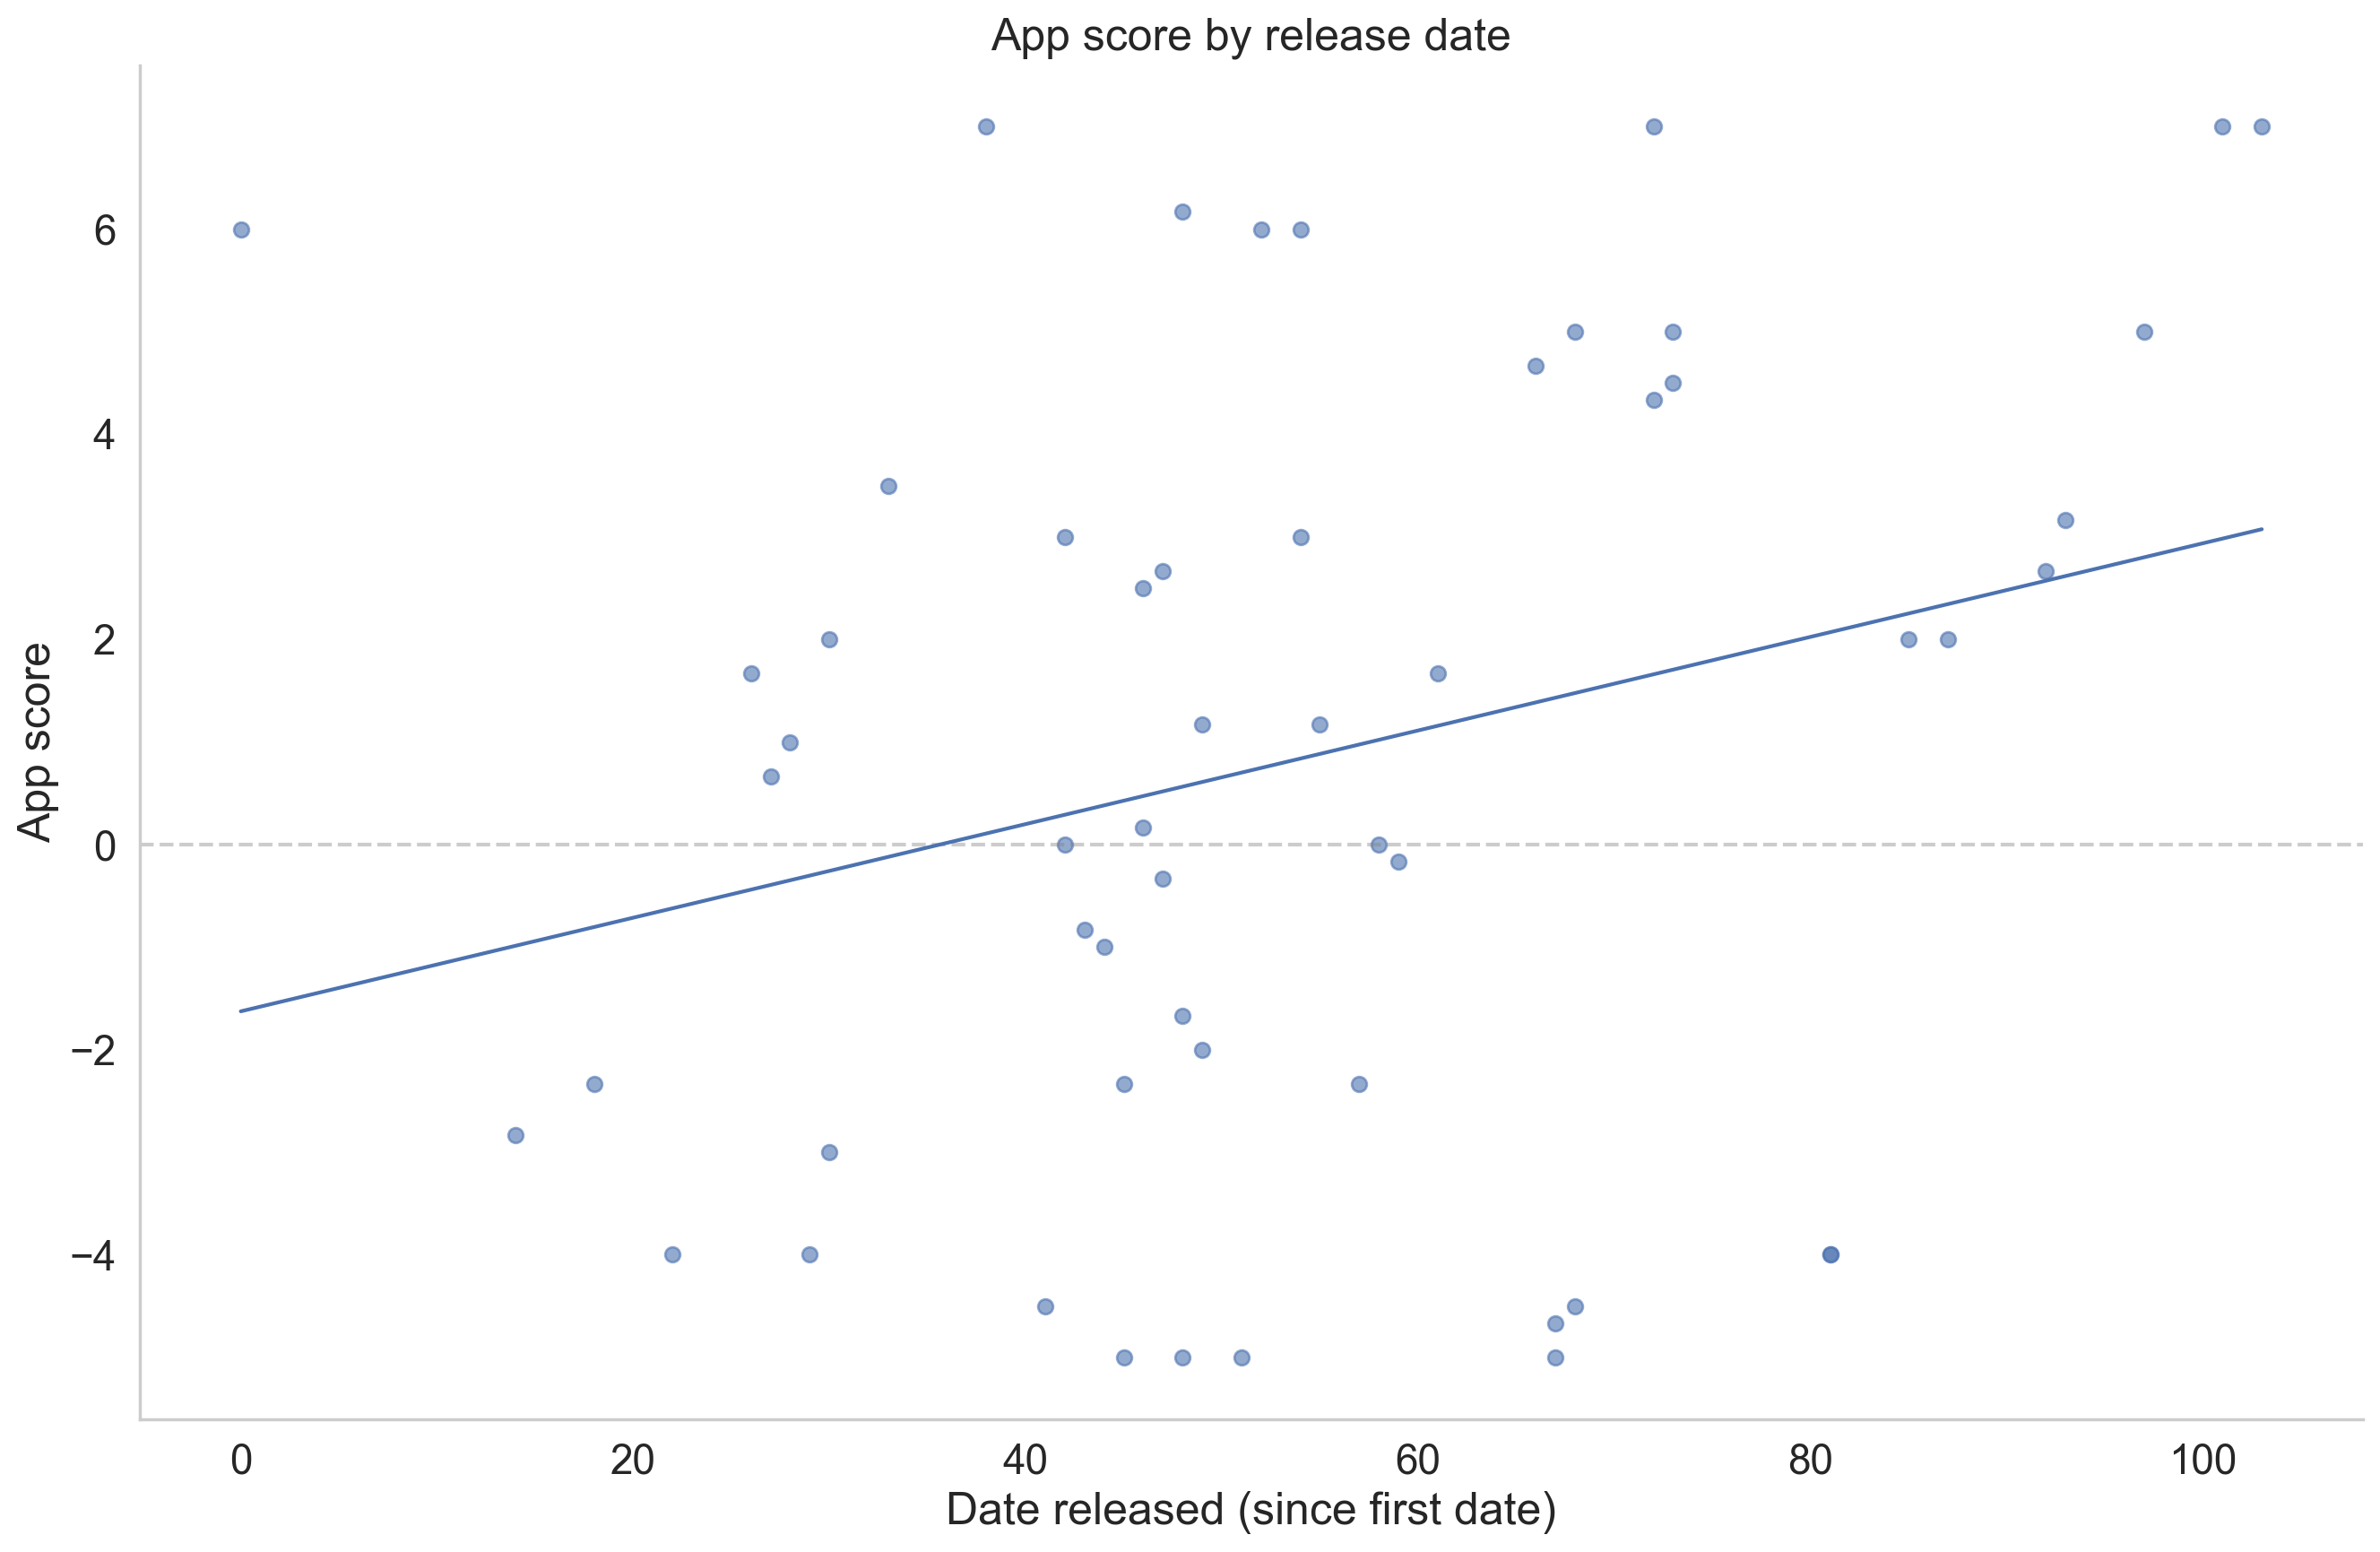

In [509]:
slope, intercept, r, p, std = sps.linregress(x, y)
plt.figure(dpi=200, figsize=(16, 10))
plt.axhline(0, color='grey', alpha=0.4, linestyle='--')
plt.scatter(x, y, alpha=0.6)

xx = np.linspace(0, max(x))
plt.plot(xx, xx * slope + intercept)
plt.xlabel("Date released (since first date)")
plt.ylabel("App score")
plt.title("App score by release date")
plt.grid(b=None)
ax = plt.gca()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
plt.savefig(config.figs / 'app_score_by_release_date.png', dpi=200, figsize=(16, 10))

# 